### In this project, First a low resolution Night image is used as an input. After super resolution using Real-ESRGAN  and having high resolution night image, this night image is translated to day image using CUT

In [5]:
from PIL import Image, ImageChops
import math
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import os
import torch
import torch.nn.functional as F
import statistics
from sklearn.metrics.cluster import normalized_mutual_info_score

# RSME

In [6]:
def rmsdiff(im1, im2):
    """Calculates the root mean square error (RSME) between two images"""
    errors = np.asarray(ImageChops.difference(im1, im2)) / 255
    return math.sqrt(np.mean(np.square(errors)))

# MAE

In [7]:
def mae(imageA, imageB):
#     the 'Mean Absolute Error' between the two images is the
#     Average of the difference between the two images;
#     NOTE: the two images must have the same dimension   
    errors = np.asarray(ImageChops.difference(imageA, imageB)) / 255
    return np.mean((errors))

# MSE

In [8]:
def mse(imageA, imageB):
#     the 'Mean Squared Error' between the two images is the
#     sum of the squared difference between the two images;
#     NOTE: the two images must have the same dimension
    
    errors = np.asarray(ImageChops.difference(imageA, imageB)) / 255
    return np.mean(np.square(errors))

# PSNR

In [9]:
import numpy 
import math
import cv2
def psnr(img1, img2):
    mse = numpy.mean( np.asarray(ImageChops.difference(img1, img2)) ** 2 )
    if mse == 0:
     return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

# SSIM

In [10]:
def gaussian(window_size, sigma):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """    
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()





def create_window(window_size, channel=1):

    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    
    # Converting to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
     
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

    return window






def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret

# Mutual Information

In [11]:
def mutual_information(hgram):
    """ Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [153]:
Ground_truth_folder_path = '/home/aabedjoo/Aref_project/Main_Dataset/day/test/'
Night_Ground_truth_folder_path = '/home/aabedjoo/Aref_project/Main_Dataset/night/test/'
HR_Gen_night_folder_path = '/home/aabedjoo/Aref_project/Final_results/M2-A1/HR_Generated_Night/'
HR_Gen_day_folder_path = '/home/aabedjoo/Aref_project/Final_results/M2-A1/HR_Gen_Day/'
LR_night_folder_path = '/home/aabedjoo/Aref_project/Final_results/M2-A1/LR_Night/'

# phase1 : LR_night_image VS Ground_truth_image

In [14]:
# Helper functions to convert to Tensors
tensorify = lambda x: torch.Tensor(x.transpose((2, 0, 1))).unsqueeze(0).float().div(255.0)


import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts



only_files = [f for f in listdir(LR_night_folder_path) if isfile(join(LR_night_folder_path, f))]
only_files.sort(key=numericalSort)
# print(only_files)


RMSE_phase1_dict = {}
MSE_phase1_dict = {}
MAE_phase1_dict = {}
PSNR_phase1_dict = {}
SSIM_phase1_dict = {}
# MI_phase1_dict = {} # Mutual Information
# NMI_phase1_dict = {} # Normalized Mutual Information
NCC_phase1_dict = {} # Normalized Cross-Correlation


i = 0
dsize = (256, 256)
for file_name in only_files:
    filenameArr = file_name.split(".")[0]
    #load images
    LR_night_image_path = LR_night_folder_path + filenameArr + ".jpg"
    Ground_truth_image_path = Ground_truth_folder_path + filenameArr + ".jpg"
    
    # Load the original image
    LR_night_image = Image.open(LR_night_image_path)
    Ground_truth_image = Image.open(Ground_truth_image_path)
    
    # Load the image using cv2
    LR_night_image_cv2 = cv2.imread(LR_night_image_path, cv2.IMREAD_UNCHANGED)
    resized_LR_night_image_cv2 = cv2.resize(LR_night_image_cv2, dsize)
    
    Ground_truth_image_cv2 = cv2.imread(Ground_truth_image_path, cv2.IMREAD_UNCHANGED)
    
    # tensorifing cv2 images 
    LR_night_image_cv2_tensor = tensorify(resized_LR_night_image_cv2)
    Ground_truth_image_cv2_tensor = tensorify(Ground_truth_image_cv2)

    # phase1 : LR_night_image VS Ground_truth_image
    RMSE_phase1_dict[filenameArr] = rmsdiff(LR_night_image,Ground_truth_image)
    MSE_phase1_dict[filenameArr] = mse(LR_night_image,Ground_truth_image)
    MAE_phase1_dict[filenameArr] = mae(LR_night_image,Ground_truth_image)
    PSNR_phase1_dict[filenameArr] = psnr(LR_night_image,Ground_truth_image)
    
    digit_phase1 = ssim(LR_night_image_cv2_tensor, Ground_truth_image_cv2_tensor, val_range=255).detach().cpu().numpy()
    SSIM_phase1_dict[filenameArr] = float(digit_phase1)
    
#     NMI_phase1_dict[filenameArr] = normalized_mutual_info_score(resized_LR_night_image_cv2.reshape(-1),Ground_truth_image_cv2.reshape(-1))
#     hist_2d = None
#     hist_2d, x_edges, y_edges = np.histogram2d(resized_LR_night_image_cv2.ravel(), Ground_truth_image_cv2.ravel(),bins=256)
#     MI_phase1_dict[filenameArr] = mutual_information(hist_2d)
    
    NCC_phase1_dict[filenameArr] = float(cv2.matchTemplate(resized_LR_night_image_cv2, Ground_truth_image_cv2, cv2.TM_CCORR_NORMED))
    print(i)
    i = i + 1 
#     if i > 1:
#         break
    
print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011


In [13]:
# print(NMI_phase1_dict_test)

{'25': 5.253295173774916, '31': 4.9005100988289545}


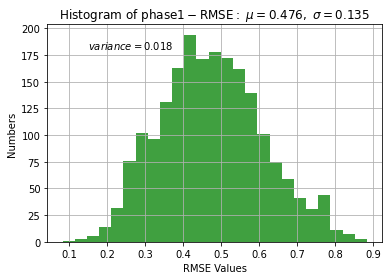

In [125]:
variance_RMSE_phase1 = statistics.pvariance(RMSE_phase1_dict.values())
sigma_RMSE_phase1 = statistics.pstdev(RMSE_phase1_dict.values())
mu_RMSE_phase1 = statistics.mean(RMSE_phase1_dict.values())
                          
# the histogram of the data
n, bins, patches = plt.hist(RMSE_phase1_dict.values(),25, facecolor='green', alpha=0.75)

#plot
plt.xlabel('RMSE Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 1- RMSE:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_RMSE_phase1, sigma_RMSE_phase1))
plt.text(0.15, 180, r'$variance=%.3f$' %(variance_RMSE_phase1))
plt.grid(True)
plt.show()

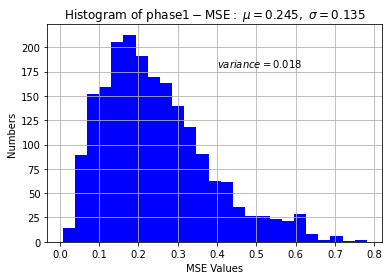

In [126]:
variance_MSE_phase1 = statistics.pvariance(MSE_phase1_dict.values())
sigma_MSE_phase1 = statistics.pstdev(MSE_phase1_dict.values())
mu_MSE_phase1 = statistics.mean(MSE_phase1_dict.values())
                          
# the histogram of the data
n, bins, patches = plt.hist(MSE_phase1_dict.values(),25, facecolor='blue')

#plot
plt.xlabel('MSE Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 1- MSE:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_MSE_phase1, sigma_MSE_phase1))
plt.text(0.4, 180, r'$variance=%.3f$' %(variance_MSE_phase1))
plt.grid(True)
plt.show()

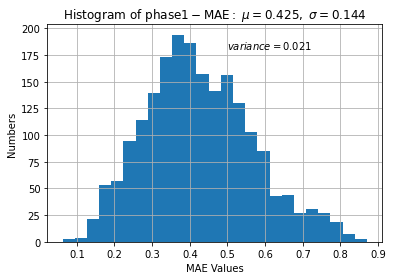

In [127]:
variance_MAE_phase1 = statistics.pvariance(MAE_phase1_dict.values())
sigma_MAE_phase1 = statistics.pstdev(MAE_phase1_dict.values())
mu_MAE_phase1 = statistics.mean(MAE_phase1_dict.values())
                          

# the histogram of the data
n, bins, patches = plt.hist(MAE_phase1_dict.values(),25)
#plot
plt.xlabel('MAE Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 1- MAE:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_MAE_phase1, sigma_MAE_phase1))
plt.text(0.5, 180, r'$variance=%.3f$' %(variance_MAE_phase1))
plt.grid(True)
plt.show()

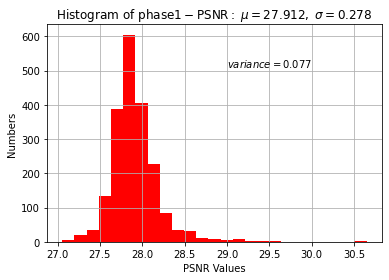

In [128]:
variance_PSNR_phase1 = statistics.pvariance(PSNR_phase1_dict.values())
sigma_PSNR_phase1 = statistics.pstdev(PSNR_phase1_dict.values())
mu_PSNR_phase1 = statistics.mean(PSNR_phase1_dict.values())
                          

plt.hist(PSNR_phase1_dict.values(),25, facecolor='red')
#plot
plt.xlabel('PSNR Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 1- PSNR:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_PSNR_phase1, sigma_PSNR_phase1))
plt.text(29, 510, r'$variance=%.3f$' %(variance_PSNR_phase1))
plt.grid(True)
plt.show()

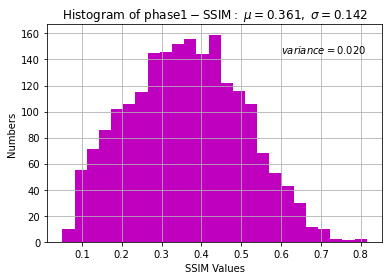

In [129]:
variance_SSIM_phase1 = statistics.pvariance(SSIM_phase1_dict.values())
sigma_SSIM_phase1 = statistics.pstdev(SSIM_phase1_dict.values())
mu_SSIM_phase1 = statistics.mean(SSIM_phase1_dict.values())
                          

plt.hist(SSIM_phase1_dict.values(),25, facecolor='m')
#plot
plt.xlabel('SSIM Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 1- SSIM:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_SSIM_phase1, sigma_SSIM_phase1))
plt.text(0.6, 145, r'$variance=%.3f$' %(variance_SSIM_phase1))
plt.grid(True)
plt.show()

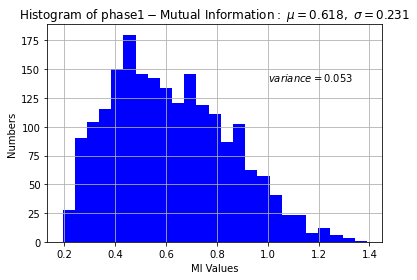

In [20]:
variance_MI_phase1 = statistics.pvariance(MI_phase1_dict.values())
sigma_MI_phase1 = statistics.pstdev(MI_phase1_dict.values())
mu_MI_phase1 = statistics.mean(MI_phase1_dict.values())
                          

plt.hist(MI_phase1_dict.values(),25, facecolor='b')
#plot
plt.xlabel('MI Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 1- Mutual\ Information:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_MI_phase1, sigma_MI_phase1))
plt.text(1, 140, r'$variance=%.3f$' %(variance_MI_phase1))
plt.grid(True)
plt.show()

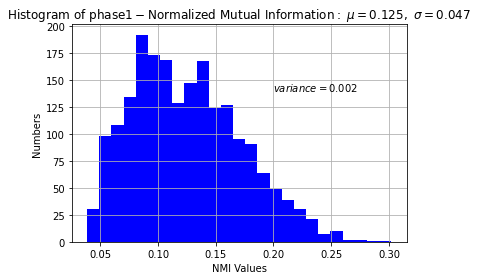

In [21]:
variance_NMI_phase1 = statistics.pvariance(NMI_phase1_dict.values())
sigma_NMI_phase1 = statistics.pstdev(NMI_phase1_dict.values())
mu_NMI_phase1 = statistics.mean(NMI_phase1_dict.values())
                          

plt.hist(NMI_phase1_dict.values(),25, facecolor='b')
#plot
plt.xlabel('NMI Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 1- Normalized\ Mutual\ Information:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_NMI_phase1, sigma_NMI_phase1))
plt.text(0.2, 140, r'$variance=%.3f$' %(variance_NMI_phase1))
plt.grid(True)
plt.show()

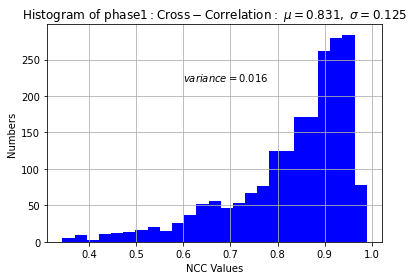

In [130]:
variance_NCC_phase1 = statistics.pvariance(NCC_phase1_dict.values())
sigma_NCC_phase1 = statistics.pstdev(NCC_phase1_dict.values())
mu_NCC_phase1 = statistics.mean(NCC_phase1_dict.values())
                          

plt.hist(NCC_phase1_dict.values(),25, color='b')
#plot
plt.xlabel('NCC Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 1: Cross-Correlation:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_NCC_phase1, sigma_NCC_phase1))
plt.text(0.6, 220, r'$variance=%.3f$' %(variance_NCC_phase1))
plt.grid(True)
plt.show()

## FID

In [391]:
!python -m pytorch_fid /home/aabedjoo/Aref_project/Final_results/M2-A1/LR_Night/ /home/aabedjoo/Aref_project/Main_Dataset/day/test/ --device cuda:0 --dims 768

100%|███████████████████████████████████████████| 41/41 [00:07<00:00,  5.84it/s]
FID:  0.9344608128105114


In [147]:
!python -m pytorch_fid /home/aabedjoo/Aref_project/Final_results/M2-A1/LR_Night/ /home/aabedjoo/Aref_project/Main_Dataset/day/test/ --device cuda:0

100%|███████████████████████████████████████████| 41/41 [00:08<00:00,  5.11it/s]
FID:  173.94727033852934


In [148]:
FID_phase1 = 173.94727033852934

In [392]:
!python -m pytorch_fid /home/aabedjoo/Aref_project/Main_Dataset/day/test/ /home/aabedjoo/Aref_project/Main_Dataset/day/test/ --device cuda:0 --dims 768

100%|███████████████████████████████████████████| 41/41 [00:06<00:00,  5.91it/s]
FID:  1.9984014443252818e-15


# Phase2 : HR_Gen_night_image VS Ground_truth_image

In [26]:
# Helper functions to convert to Tensors
tensorify = lambda x: torch.Tensor(x.transpose((2, 0, 1))).unsqueeze(0).float().div(255.0)


import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts



only_files = [f for f in listdir(LR_night_folder_path) if isfile(join(LR_night_folder_path, f))]
only_files.sort(key=numericalSort)
# print(only_files)



RMSE_phase2_dict = {}
MSE_phase2_dict = {}
MAE_phase2_dict = {}
PSNR_phase2_dict = {}
SSIM_phase2_dict = {}
# MI_phase2_dict = {} # Mutual Information
# NMI_phase2_dict = {} # Normalized Mutual Information
NCC_phase2_dict = {} # Normalized Cross-Correlation

i = 0
dsize = (256, 256)
for file_name in only_files:
    filenameArr = file_name.split(".")[0]
    #load images
    #load images
    HR_Gen_night_image_path = HR_Gen_night_folder_path + filenameArr + "_out.jpg"
    Ground_truth_image_path = Ground_truth_folder_path + filenameArr + ".jpg"
    
    # Load the original image
    HR_Gen_night_image = Image.open(HR_Gen_night_image_path)
    Ground_truth_image = Image.open(Ground_truth_image_path)
    
    # Load the image using cv2
    HR_Gen_night_image_cv2 = cv2.imread(HR_Gen_night_image_path, cv2.IMREAD_UNCHANGED)
    Ground_truth_image_cv2 = cv2.imread(Ground_truth_image_path, cv2.IMREAD_UNCHANGED)
    
    # tensorifing cv2 images 
    HR_Gen_night_image_cv2_tensor = tensorify(HR_Gen_night_image_cv2)
    Ground_truth_image_cv2_tensor = tensorify(Ground_truth_image_cv2)

    
    # phase2 : HR_Gen_night_image VS Ground_truth_image
    RMSE_phase2_dict[filenameArr] = rmsdiff(HR_Gen_night_image,Ground_truth_image)
    MSE_phase2_dict[filenameArr] = mse(HR_Gen_night_image,Ground_truth_image)
    MAE_phase2_dict[filenameArr] = mae(HR_Gen_night_image,Ground_truth_image)
    PSNR_phase2_dict[filenameArr] = psnr(HR_Gen_night_image,Ground_truth_image)
    
    digit_phase2 = ssim(HR_Gen_night_image_cv2_tensor, Ground_truth_image_cv2_tensor, val_range=255).detach().cpu().numpy()
    SSIM_phase2_dict[filenameArr] = float(digit_phase2)
    
    
#     hist_2d = None
#     hist_2d, x_edges, y_edges = np.histogram2d(HR_Gen_night_image_cv2.ravel(), Ground_truth_image_cv2.ravel(),bins=256)
#     MI_phase2_dict[filenameArr] = mutual_information(hist_2d)
    
#     NMI_phase2_dict[filenameArr] = normalized_mutual_info_score(HR_Gen_night_image_cv2.reshape(-1),Ground_truth_image_cv2.reshape(-1))
    
    NCC_phase2_dict[filenameArr] = float(cv2.matchTemplate(HR_Gen_night_image_cv2, Ground_truth_image_cv2, cv2.TM_CCORR_NORMED))
    
    print(i)
    i = i + 1 
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010


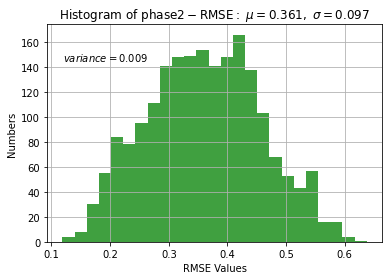

In [131]:
variance_RMSE_phase2 = statistics.pvariance(RMSE_phase2_dict.values())
sigma_RMSE_phase2 = statistics.pstdev(RMSE_phase2_dict.values())
mu_RMSE_phase2 = statistics.mean(RMSE_phase2_dict.values())
                          
# the histogram of the data
n, bins, patches = plt.hist(RMSE_phase2_dict.values(),25, facecolor='green', alpha=0.75)

#plot
plt.xlabel('RMSE Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 2- RMSE:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_RMSE_phase2, sigma_RMSE_phase2))
plt.text(0.12, 145, r'$variance=%.3f$' %(variance_RMSE_phase2))
plt.grid(True)
plt.show()

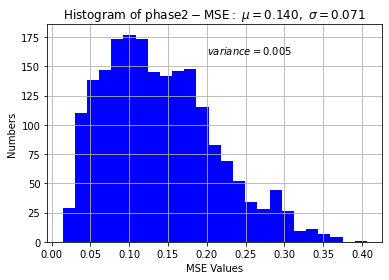

In [132]:
variance_MSE_phase2 = statistics.pvariance(MSE_phase2_dict.values())
sigma_MSE_phase2 = statistics.pstdev(MSE_phase2_dict.values())
mu_MSE_phase2 = statistics.mean(MSE_phase2_dict.values())
                          
# the histogram of the data
n, bins, patches = plt.hist(MSE_phase2_dict.values(),25, facecolor='blue')

#plot
plt.xlabel('MSE Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 2- MSE:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_MSE_phase2, sigma_MSE_phase2))
plt.text(0.2, 160, r'$variance=%.3f$' %(variance_MSE_phase2))
plt.grid(True)
plt.show()

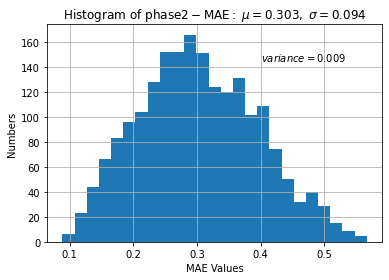

In [133]:
variance_MAE_phase2 = statistics.pvariance(MAE_phase2_dict.values())
sigma_MAE_phase2 = statistics.pstdev(MAE_phase2_dict.values())
mu_MAE_phase2 = statistics.mean(MAE_phase2_dict.values())
                          

# the histogram of the data
n, bins, patches = plt.hist(MAE_phase2_dict.values(),25)
#plot
plt.xlabel('MAE Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 2- MAE:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_MAE_phase2, sigma_MAE_phase2))
plt.text(0.4, 145, r'$variance=%.3f$' %(variance_MAE_phase2))
plt.grid(True)
plt.show()

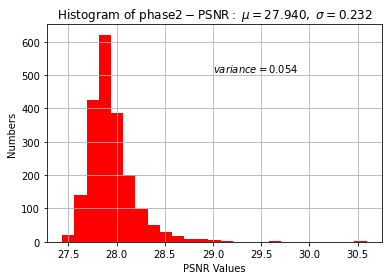

In [134]:
variance_PSNR_phase2 = statistics.pvariance(PSNR_phase2_dict.values())
sigma_PSNR_phase2 = statistics.pstdev(PSNR_phase2_dict.values())
mu_PSNR_phase2 = statistics.mean(PSNR_phase2_dict.values())
                          

plt.hist(PSNR_phase2_dict.values(),25, facecolor='red')
#plot
plt.xlabel('PSNR Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 2- PSNR:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_PSNR_phase2, sigma_PSNR_phase2))
plt.text(29, 510, r'$variance=%.3f$' %(variance_PSNR_phase2))
plt.grid(True)
plt.show()

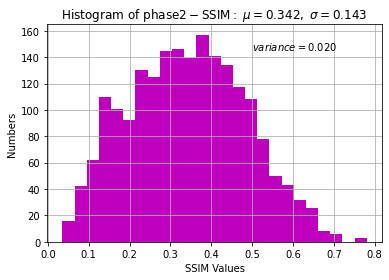

In [135]:
variance_SSIM_phase2 = statistics.pvariance(SSIM_phase2_dict.values())
sigma_SSIM_phase2 = statistics.pstdev(SSIM_phase2_dict.values())
mu_SSIM_phase2 = statistics.mean(SSIM_phase2_dict.values())
                          

plt.hist(SSIM_phase2_dict.values(),25, facecolor='m')
#plot
plt.xlabel('SSIM Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 2- SSIM:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_SSIM_phase2, sigma_SSIM_phase2))
plt.text(0.5, 145, r'$variance=%.3f$' %(variance_SSIM_phase2))
plt.grid(True)
plt.show()

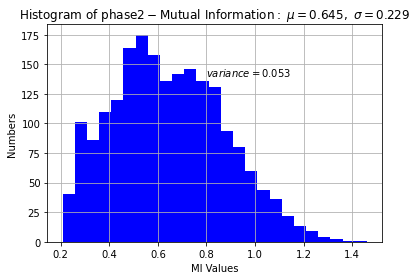

In [32]:
variance_MI_phase2 = statistics.pvariance(MI_phase2_dict.values())
sigma_MI_phase2 = statistics.pstdev(MI_phase2_dict.values())
mu_MI_phase2 = statistics.mean(MI_phase2_dict.values())
                          

plt.hist(MI_phase2_dict.values(),25, facecolor='b')
#plot
plt.xlabel('MI Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 2- Mutual\ Information:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_MI_phase2, sigma_MI_phase2))
plt.text(0.8, 140, r'$variance=%.3f$' %(variance_MI_phase2))
plt.grid(True)
plt.show()

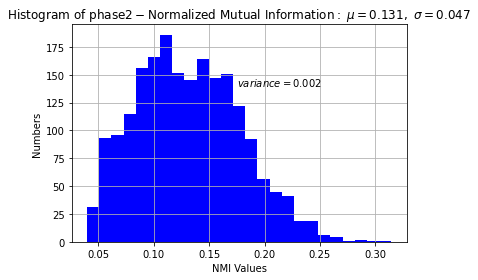

In [33]:
variance_NMI_phase2 = statistics.pvariance(NMI_phase2_dict.values())
sigma_NMI_phase2 = statistics.pstdev(NMI_phase2_dict.values())
mu_NMI_phase2 = statistics.mean(NMI_phase2_dict.values())
                          

plt.hist(NMI_phase2_dict.values(),25, facecolor='b')
#plot
plt.xlabel('NMI Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 2- Normalized\ Mutual\ Information:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_NMI_phase2, sigma_NMI_phase2))
plt.text(0.175, 140, r'$variance=%.3f$' %(variance_NMI_phase2))
plt.grid(True)
plt.show()

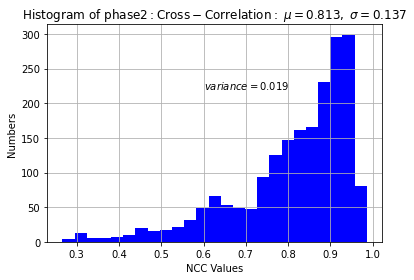

In [136]:
variance_NCC_phase2 = statistics.pvariance(NCC_phase2_dict.values())
sigma_NCC_phase2 = statistics.pstdev(NCC_phase2_dict.values())
mu_NCC_phase2 = statistics.mean(NCC_phase2_dict.values())
                          

plt.hist(NCC_phase2_dict.values(),25, color='b')
#plot
plt.xlabel('NCC Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 2: Cross-Correlation:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_NCC_phase2, sigma_NCC_phase2))
plt.text(0.6, 220, r'$variance=%.3f$' %(variance_NCC_phase2))
plt.grid(True)
plt.show()

## FID

In [38]:
!python -m pytorch_fid /home/aabedjoo/Aref_project/Final_results/M2-A1/HR_Generated_Night/ /home/aabedjoo/Aref_project/Main_Dataset/day/test/ --device cuda:0 --dims 768

100%|███████████████████████████████████████████| 41/41 [00:07<00:00,  5.58it/s]
FID:  0.7771200136525271


In [146]:
!python -m pytorch_fid /home/aabedjoo/Aref_project/Final_results/M2-A1/HR_Generated_Night/ /home/aabedjoo/Aref_project/Main_Dataset/day/test/ --device cuda:0

100%|███████████████████████████████████████████| 41/41 [00:07<00:00,  5.16it/s]
FID:  146.76235334282825


In [149]:
FID_phase2 = 146.76235334282825

# phase3 : HR_Gen_day_image VS Ground_truth_image

In [39]:
# Helper functions to convert to Tensors
tensorify = lambda x: torch.Tensor(x.transpose((2, 0, 1))).unsqueeze(0).float().div(255.0)


import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts



only_files = [f for f in listdir(LR_night_folder_path) if isfile(join(LR_night_folder_path, f))]
only_files.sort(key=numericalSort)
# print(only_files)


RMSE_phase3_dict = {}
MSE_phase3_dict = {}
MAE_phase3_dict = {}
PSNR_phase3_dict = {}
SSIM_phase3_dict = {}
# MI_phase3_dict = {} # Mutual Information
# NMI_phase3_dict = {} # Normalized Mutual Information
NCC_phase3_dict = {} # Normalized Cross-Correlation


i = 0
dsize = (256, 256)
for file_name in only_files:
    filenameArr = file_name.split(".")[0]
    #load images
    HR_Gen_day_image_path = HR_Gen_day_folder_path + filenameArr + "_out_fake_B.png"
    Ground_truth_image_path = Ground_truth_folder_path + filenameArr + ".jpg"
    
    # Load the original image
    HR_Gen_day_image = Image.open(HR_Gen_day_image_path)
    Ground_truth_image = Image.open(Ground_truth_image_path)
    
    # Load the image using cv2
    HR_Gen_day_image_cv2 = cv2.imread(HR_Gen_day_image_path, cv2.IMREAD_UNCHANGED)
    Ground_truth_image_cv2 = cv2.imread(Ground_truth_image_path, cv2.IMREAD_UNCHANGED)
    
    # tensorifing cv2 images 
    HR_Gen_day_image_cv2_tensor = tensorify(HR_Gen_day_image_cv2)
    Ground_truth_image_cv2_tensor = tensorify(Ground_truth_image_cv2)

    
    # phase3 : HR_Gen_day_image VS Ground_truth_image
    RMSE_phase3_dict[filenameArr] = rmsdiff(HR_Gen_day_image,Ground_truth_image)
    MSE_phase3_dict[filenameArr] = mse(HR_Gen_day_image,Ground_truth_image)
    MAE_phase3_dict[filenameArr] = mae(HR_Gen_day_image,Ground_truth_image)
    PSNR_phase3_dict[filenameArr] = psnr(HR_Gen_day_image,Ground_truth_image)
    
    digit_phase3 = ssim(HR_Gen_day_image_cv2_tensor, Ground_truth_image_cv2_tensor, val_range=255).detach().cpu().numpy()
    SSIM_phase3_dict[filenameArr] = float(digit_phase3) 
    
    
#     hist_2d = None
#     hist_2d, x_edges, y_edges = np.histogram2d(HR_Gen_day_image_cv2.ravel(), Ground_truth_image_cv2.ravel(),bins=256)
#     MI_phase3_dict[filenameArr] = mutual_information(hist_2d)
    
#     NMI_phase3_dict[filenameArr] = normalized_mutual_info_score(HR_Gen_day_image_cv2.reshape(-1),Ground_truth_image_cv2.reshape(-1))
    
    
    NCC_phase3_dict[filenameArr] = float(cv2.matchTemplate(HR_Gen_day_image_cv2, Ground_truth_image_cv2, cv2.TM_CCORR_NORMED))
    
    print(i)
    i = i + 1 



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010


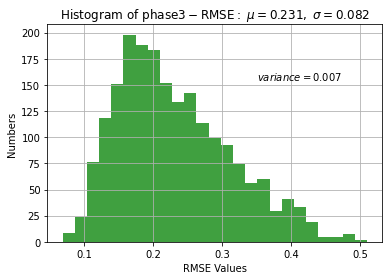

In [137]:
variance_RMSE_phase3 = statistics.pvariance(RMSE_phase3_dict.values())
sigma_RMSE_phase3 = statistics.pstdev(RMSE_phase3_dict.values())
mu_RMSE_phase3 = statistics.mean(RMSE_phase3_dict.values())
                          
# the histogram of the data
n, bins, patches = plt.hist(RMSE_phase3_dict.values(),25, facecolor='green', alpha=0.75)

#plot
plt.xlabel('RMSE Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 3- RMSE:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_RMSE_phase3, sigma_RMSE_phase3))
plt.text(0.35, 155, r'$variance=%.3f$' %(variance_RMSE_phase3))
plt.grid(True)
plt.show()

In [42]:
print("RMSE Max is" , max(RMSE_phase3_dict.values()))
print("RMSE Min is" ,min(RMSE_phase3_dict.values()))

print("RMSE Max image is ", list(RMSE_phase3_dict.keys())[list(RMSE_phase3_dict.values()).index( max(RMSE_phase3_dict.values()))],".jpg")

print("RMSE Min image is ", list(RMSE_phase3_dict.keys())[list(RMSE_phase3_dict.values()).index( min(RMSE_phase3_dict.values()))],".jpg")

RMSE Max is 0.5100705226349168
RMSE Min is 0.06874979975621229
RMSE Max image is  19431 .jpg
RMSE Min image is  3443 .jpg


Image: 3443


Text(0.5, 1.0, ' (d) Ground Truth')

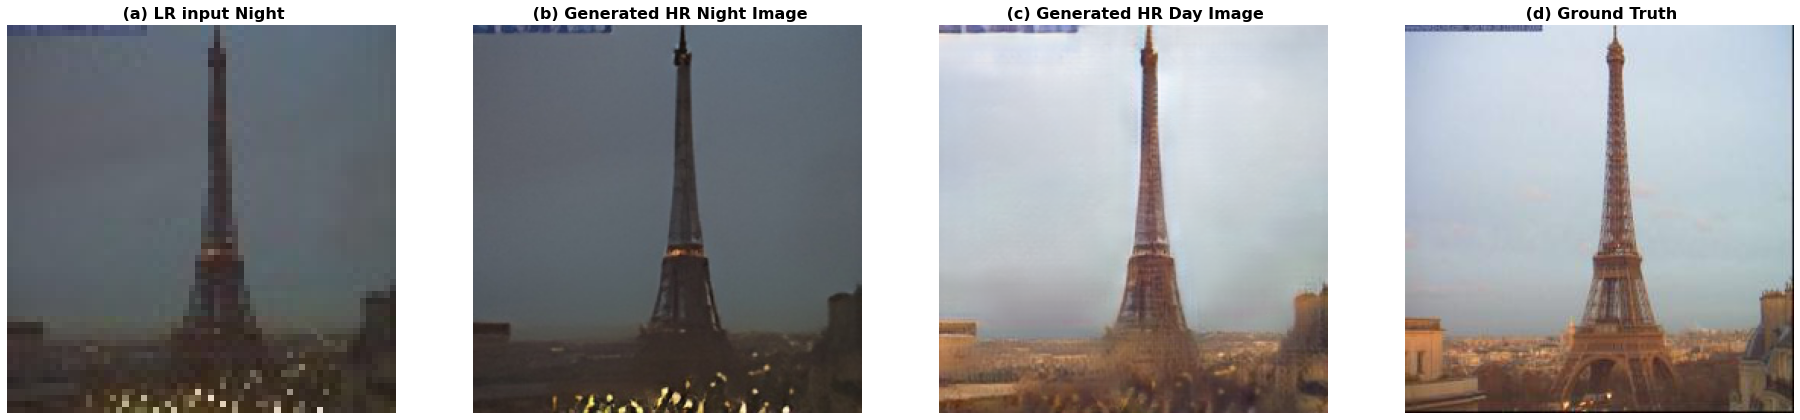

In [40]:
img_num = '3443'

print('Image:', img_num )


MIN_RMSE_LR_night_path = LR_night_folder_path + img_num + '.jpg'
MIN_RMSE_HR_Gen_night_path = HR_Gen_night_folder_path + img_num + '_out.jpg'
MIN_RMSE_HR_Gen_day_path = HR_Gen_day_folder_path + img_num + '_out_fake_B.png'
MIN_RMSE_Ground_truth_path = Ground_truth_folder_path  + img_num + '.jpg'
                

img_MIN_RMSE_LR = plt.imread(MIN_RMSE_LR_night_path)
img_MIN_RMSE_HR_Gen_night = plt.imread(MIN_RMSE_HR_Gen_night_path)
img_MIN_RMSE_HR_Gen_day = plt.imread(MIN_RMSE_HR_Gen_day_path)
img_MIN_RMSE_Ground_truth = plt.imread(MIN_RMSE_Ground_truth_path)
plt.figure(figsize=(32,32))
plt.subplot(141)
plt.imshow(img_MIN_RMSE_LR)
plt.axis('off')
plt.title(' (a) LR input Night',fontweight="bold", size=16) # Title
plt.subplot(142)
plt.imshow(img_MIN_RMSE_HR_Gen_night)
plt.axis('off')
plt.title(' (b) Generated HR Night Image',fontweight="bold", size=16) # Title
plt.subplot(143)
plt.imshow(img_MIN_RMSE_HR_Gen_day)
plt.axis('off')
plt.title(' (c) Generated HR Day Image',fontweight="bold", size=16) # Title
plt.subplot(144)
plt.imshow(img_MIN_RMSE_Ground_truth)
plt.axis('off')
plt.title(' (d) Ground Truth',fontweight="bold", size=16) # Title

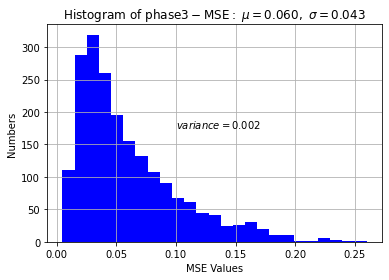

In [138]:
variance_MSE_phase3 = statistics.pvariance(MSE_phase3_dict.values())
sigma_MSE_phase3 = statistics.pstdev(MSE_phase3_dict.values())
mu_MSE_phase3 = statistics.mean(MSE_phase3_dict.values())
                          
# the histogram of the data
n, bins, patches = plt.hist(MSE_phase3_dict.values(),25, facecolor='blue')

#plot
plt.xlabel('MSE Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 3- MSE:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_MSE_phase3, sigma_MSE_phase3))
plt.text(0.1, 175, r'$variance=%.3f$' %(variance_MSE_phase3))
plt.grid(True)
plt.show()

In [42]:
print("MSE Max is" , max(MSE_phase3_dict.values()))
print("MSE Min is" ,min(MSE_phase3_dict.values()))

print("MSE Max image is ", list(MSE_phase3_dict.keys())[list(MSE_phase3_dict.values()).index( max(MSE_phase3_dict.values()))],".jpg")

print("MSE Min image is ", list(MSE_phase3_dict.keys())[list(MSE_phase3_dict.values()).index( min(MSE_phase3_dict.values()))],".jpg")

MSE Max is 0.2601719380610572
MSE Min is 0.0047265349665192875
MSE Max image is  19431 .jpg
MSE Min image is  3443 .jpg


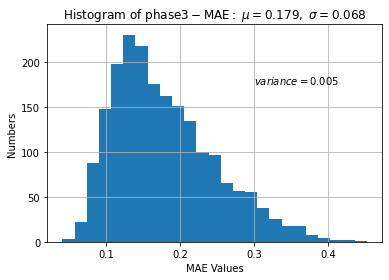

In [139]:
variance_MAE_phase3 = statistics.pvariance(MAE_phase3_dict.values())
sigma_MAE_phase3 = statistics.pstdev(MAE_phase3_dict.values())
mu_MAE_phase3 = statistics.mean(MAE_phase3_dict.values())
                          

# the histogram of the data
n, bins, patches = plt.hist(MAE_phase3_dict.values(),25)
#plot
plt.xlabel('MAE Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 3- MAE:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_MAE_phase3, sigma_MAE_phase3))
plt.text(0.3, 175, r'$variance=%.3f$' %(variance_MAE_phase3))
plt.grid(True)
plt.show()

In [44]:
print("MAE Max is" , max(MAE_phase3_dict.values()))
print("MAE Min is" ,min(MAE_phase3_dict.values()))

print("MAE Max image is ", list(MAE_phase3_dict.keys())[list(MAE_phase3_dict.values()).index( max(MAE_phase3_dict.values()))],".jpg")

print("MAE Min image is ", list(MAE_phase3_dict.keys())[list(MAE_phase3_dict.values()).index( min(MAE_phase3_dict.values()))],".jpg")

MAE Max is 0.4524858262803821
MAE Min is 0.041063216464971394
MAE Max image is  19431 .jpg
MAE Min image is  3443 .jpg


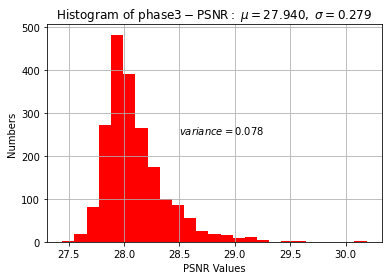

In [140]:
variance_PSNR_phase3 = statistics.pvariance(PSNR_phase3_dict.values())
sigma_PSNR_phase3 = statistics.pstdev(PSNR_phase3_dict.values())
mu_PSNR_phase3 = statistics.mean(PSNR_phase3_dict.values())
                          

plt.hist(PSNR_phase3_dict.values(),25, facecolor='red')
#plot
plt.xlabel('PSNR Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 3- PSNR:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_PSNR_phase2, sigma_PSNR_phase3))
plt.text(28.5, 250, r'$variance=%.3f$' %(variance_PSNR_phase3))
plt.grid(True)
plt.show()

In [46]:
print("PSNR Max is" , max(PSNR_phase3_dict.values()))
print("PSNR Min is" ,min(PSNR_phase3_dict.values()))

print("PSNR Max image is ", list(PSNR_phase3_dict.keys())[list(PSNR_phase3_dict.values()).index( max(PSNR_phase3_dict.values()))],".jpg")

print("PSNR Min image is ", list(PSNR_phase3_dict.keys())[list(PSNR_phase3_dict.values()).index( min(PSNR_phase3_dict.values()))],".jpg")

PSNR Max is 30.19092055163684
PSNR Min is 27.44226064907389
PSNR Max image is  3443 .jpg
PSNR Min image is  3675 .jpg


Image: 3443


Text(0.5, 1.0, ' (d) Ground Truth')

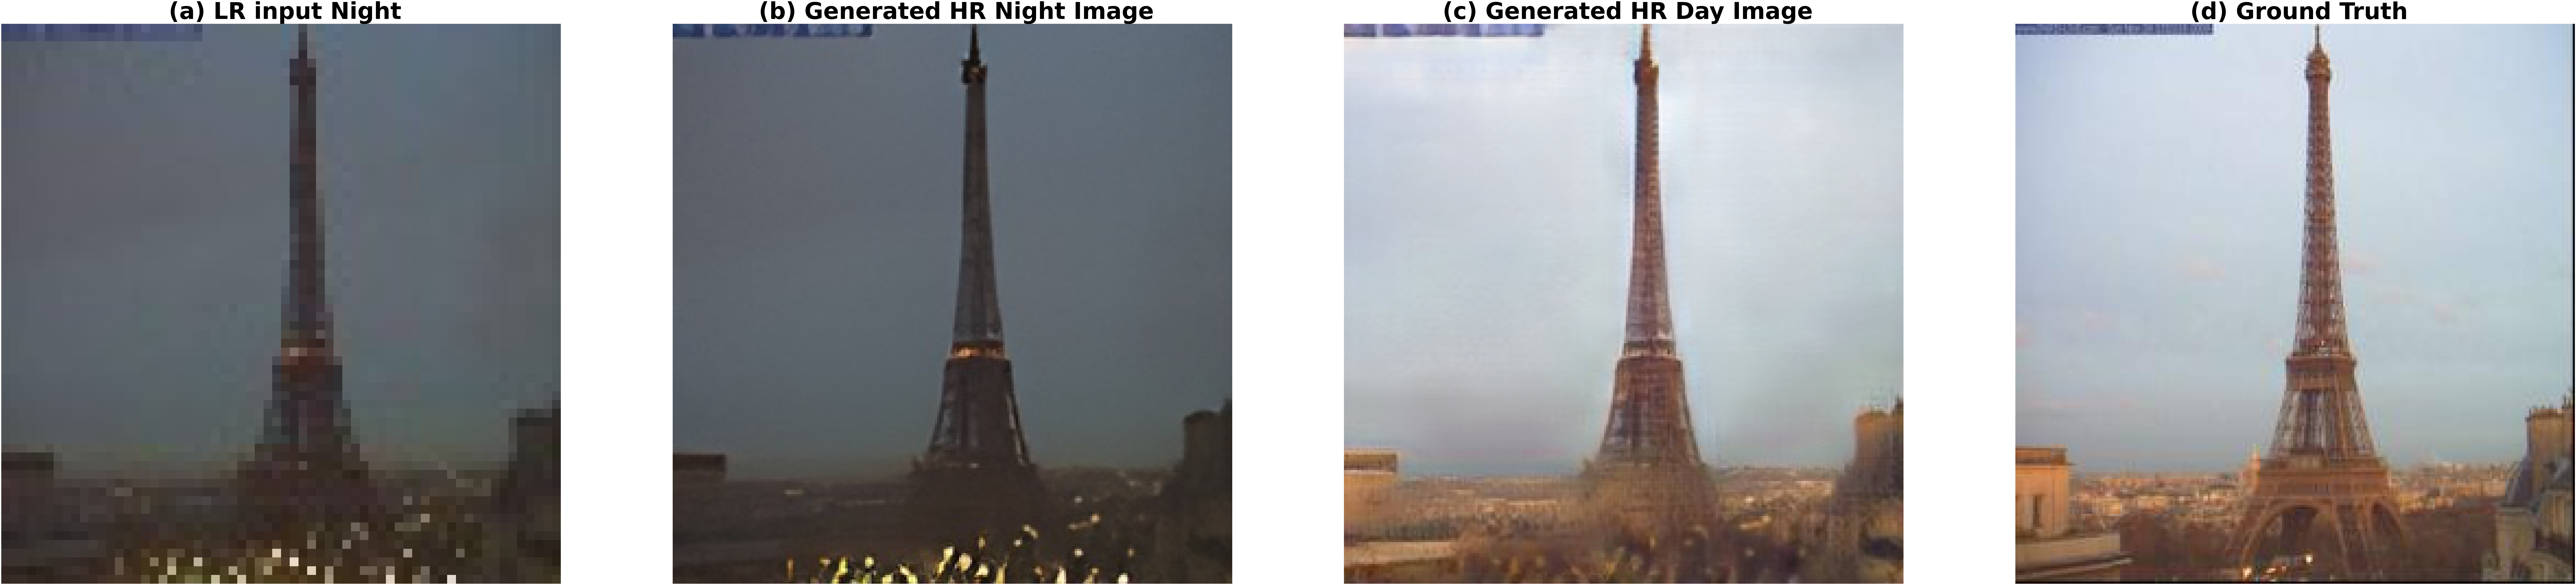

In [47]:
img_num = '3443'

print('Image:', img_num )


MAX_PSNR_LR_night_path = LR_night_folder_path + img_num + '.jpg'
MAX_PSNR_HR_Gen_night_path = HR_Gen_night_folder_path + img_num + '_out.jpg'
MAX_PSNR_HR_Gen_day_path = HR_Gen_day_folder_path + img_num + '_out_fake_B.png'
MAX_PSNR_Ground_truth_path = Ground_truth_folder_path  + img_num + '.jpg'
                

img_MAX_PSNR_LR = plt.imread(MAX_PSNR_LR_night_path)
img_MAX_PSNR_HR_Gen_night = plt.imread(MAX_PSNR_HR_Gen_night_path)
img_MAX_PSNR_HR_Gen_day = plt.imread(MAX_PSNR_HR_Gen_day_path)
img_MAX_PSNR_Ground_truth = plt.imread(MAX_PSNR_Ground_truth_path)
plt.figure(figsize=(256,256))
plt.subplot(141)
plt.imshow(img_MAX_PSNR_LR)
plt.axis('off')
plt.title(' (a) LR input Night',fontweight="bold", size=128) # Title
plt.subplot(142)
plt.imshow(img_MAX_PSNR_HR_Gen_night)
plt.axis('off')
plt.title(' (b) Generated HR Night Image',fontweight="bold", size=128) # Title
plt.subplot(143)
plt.imshow(img_MAX_PSNR_HR_Gen_day)
plt.axis('off')
plt.title(' (c) Generated HR Day Image',fontweight="bold", size=128) # Title
plt.subplot(144)
plt.imshow(img_MAX_PSNR_Ground_truth)
plt.axis('off')
plt.title(' (d) Ground Truth',fontweight="bold", size=128) # Title

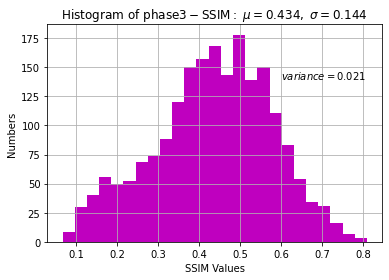

In [141]:
variance_SSIM_phase3 = statistics.pvariance(SSIM_phase3_dict.values())
sigma_SSIM_phase3 = statistics.pstdev(SSIM_phase3_dict.values())
mu_SSIM_phase3 = statistics.mean(SSIM_phase3_dict.values())
                          

plt.hist(SSIM_phase3_dict.values(),25, facecolor='m')
#plot
plt.xlabel('SSIM Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 3- SSIM:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_SSIM_phase3, sigma_SSIM_phase3))
plt.text(0.6, 140, r'$variance=%.3f$' %(variance_SSIM_phase3))
plt.grid(True)
plt.show()

In [49]:
print("SSIM Max is" , max(SSIM_phase3_dict.values()))
print("SSIM Min is" ,min(SSIM_phase3_dict.values()))

print("SSIM Max image is ", list(SSIM_phase3_dict.keys())[list(SSIM_phase3_dict.values()).index( max(SSIM_phase3_dict.values()))],".jpg")

print("SSIM Min image is ", list(SSIM_phase3_dict.keys())[list(SSIM_phase3_dict.values()).index( min(SSIM_phase3_dict.values()))],".jpg")

SSIM Max is 0.8100161552429199
SSIM Min is 0.0661538690328598
SSIM Max image is  1739 .jpg
SSIM Min image is  12865 .jpg


Image: 1739


Text(0.5, 1.0, ' (d) Ground Truth')

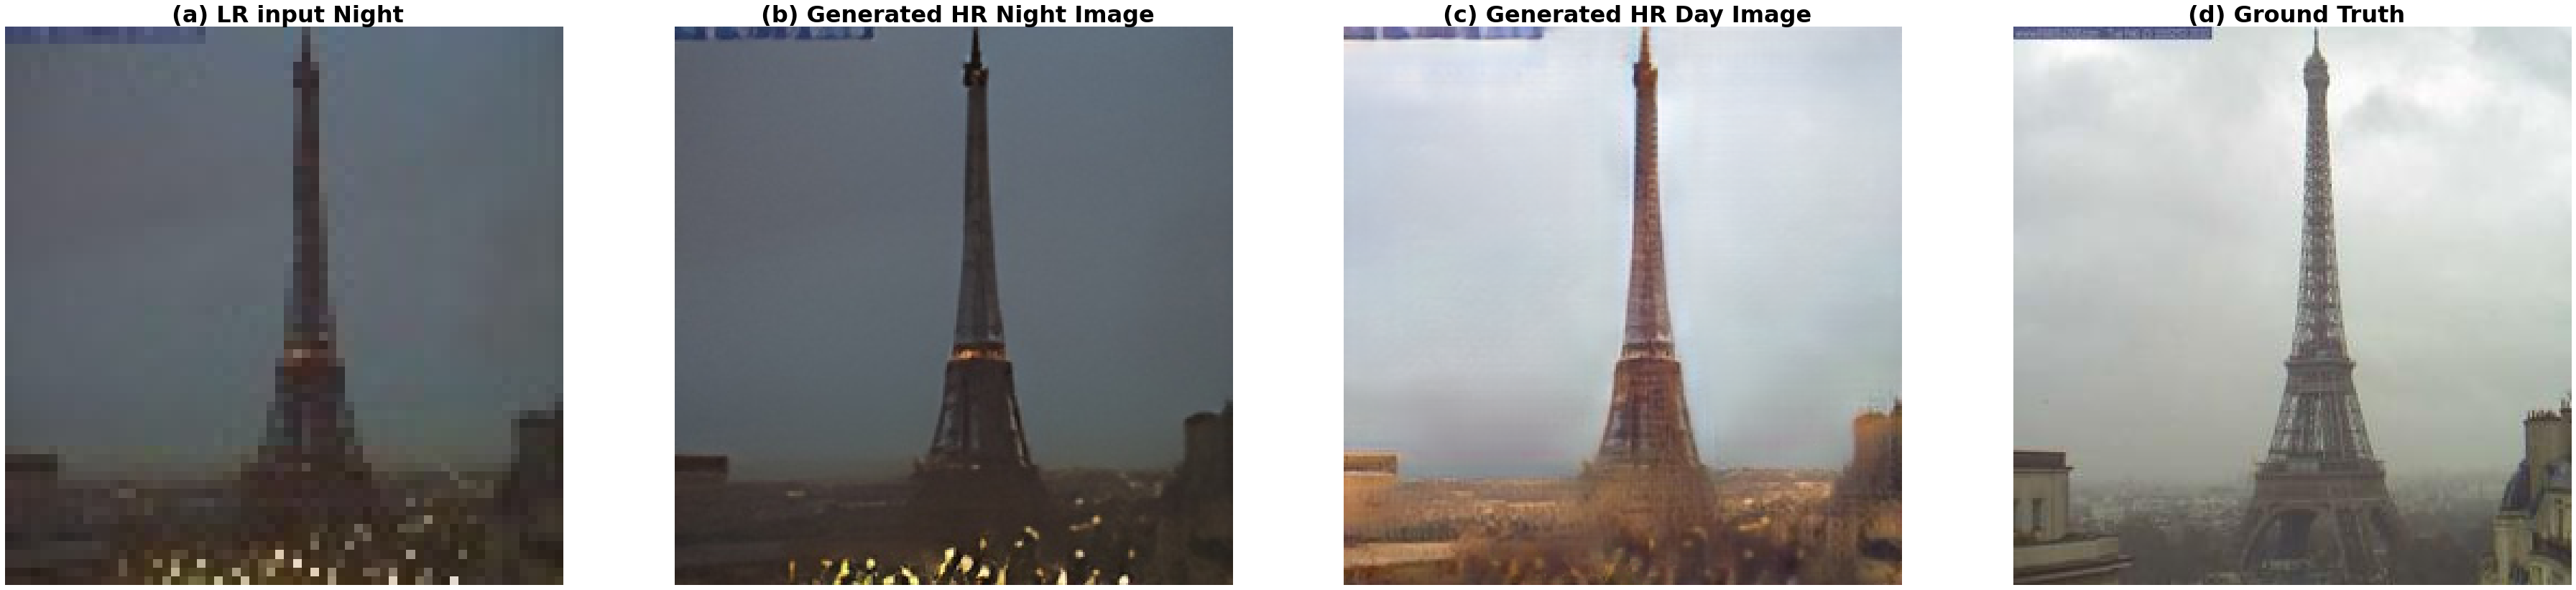

In [50]:
img_num = '1739'

print('Image:', img_num )


MAX_SSIM_LR_night_path = LR_night_folder_path + img_num + '.jpg'
MAX_SSIM_HR_Gen_night_path = HR_Gen_night_folder_path + img_num + '_out.jpg'
MAX_SSIM_HR_Gen_day_path = HR_Gen_day_folder_path + img_num + '_out_fake_B.png'
MAX_SSIM_Ground_truth_path = Ground_truth_folder_path  + img_num + '.jpg'
                

img_MAX_SSIM_LR = plt.imread(MAX_SSIM_LR_night_path)
img_MAX_SSIM_HR_Gen_night = plt.imread(MAX_SSIM_HR_Gen_night_path)
img_MAX_SSIM_HR_Gen_day = plt.imread(MAX_SSIM_HR_Gen_day_path)
img_MAX_SSIM_Ground_truth = plt.imread(MAX_SSIM_Ground_truth_path)
plt.figure(figsize=(64,64))
plt.subplot(141)
plt.imshow(img_MAX_SSIM_LR)
plt.axis('off')
plt.title(' (a) LR input Night',fontweight="bold", size=32) # Title
plt.subplot(142)
plt.imshow(img_MAX_SSIM_HR_Gen_night)
plt.axis('off')
plt.title(' (b) Generated HR Night Image',fontweight="bold", size=32) # Title
plt.subplot(143)
plt.imshow(img_MAX_SSIM_HR_Gen_day)
plt.axis('off')
plt.title(' (c) Generated HR Day Image',fontweight="bold", size=32) # Title
plt.subplot(144)
plt.imshow(img_MAX_SSIM_Ground_truth)
plt.axis('off')
plt.title(' (d) Ground Truth',fontweight="bold", size=32) # Title

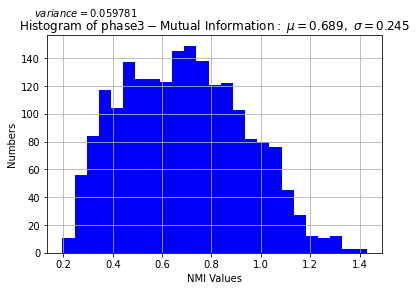

In [51]:
variance_MI_phase3 = statistics.pvariance(MI_phase3_dict.values())
sigma_MI_phase3 = statistics.pstdev(MI_phase3_dict.values())
mu_MI_phase3 = statistics.mean(MI_phase3_dict.values())
                          

plt.hist(MI_phase3_dict.values(),25, facecolor='b')
#plot
plt.xlabel('NMI Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 3- Mutual\ Information:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_MI_phase3, sigma_MI_phase3))
plt.text(0.08, 170, r'$variance=%.6f$' %(variance_MI_phase3))
plt.grid(True)
plt.show()

In [52]:
print("MI Max is" , max(MI_phase3_dict.values()))
print("MI Min is" ,min(MI_phase3_dict.values()))

print("MI Max image is ", list(MI_phase3_dict.keys())[list(MI_phase3_dict.values()).index( max(MI_phase3_dict.values()))],".jpg")

print("MI Min image is ", list(MI_phase3_dict.keys())[list(MI_phase3_dict.values()).index( min(MI_phase3_dict.values()))],".jpg")

MI Max is 1.4293834551928213
MI Min is 0.1960298569198133
MI Max image is  12043 .jpg
MI Min image is  5112 .jpg


Image: 7014


Text(0.5, 1.0, ' (d) Ground Truth')

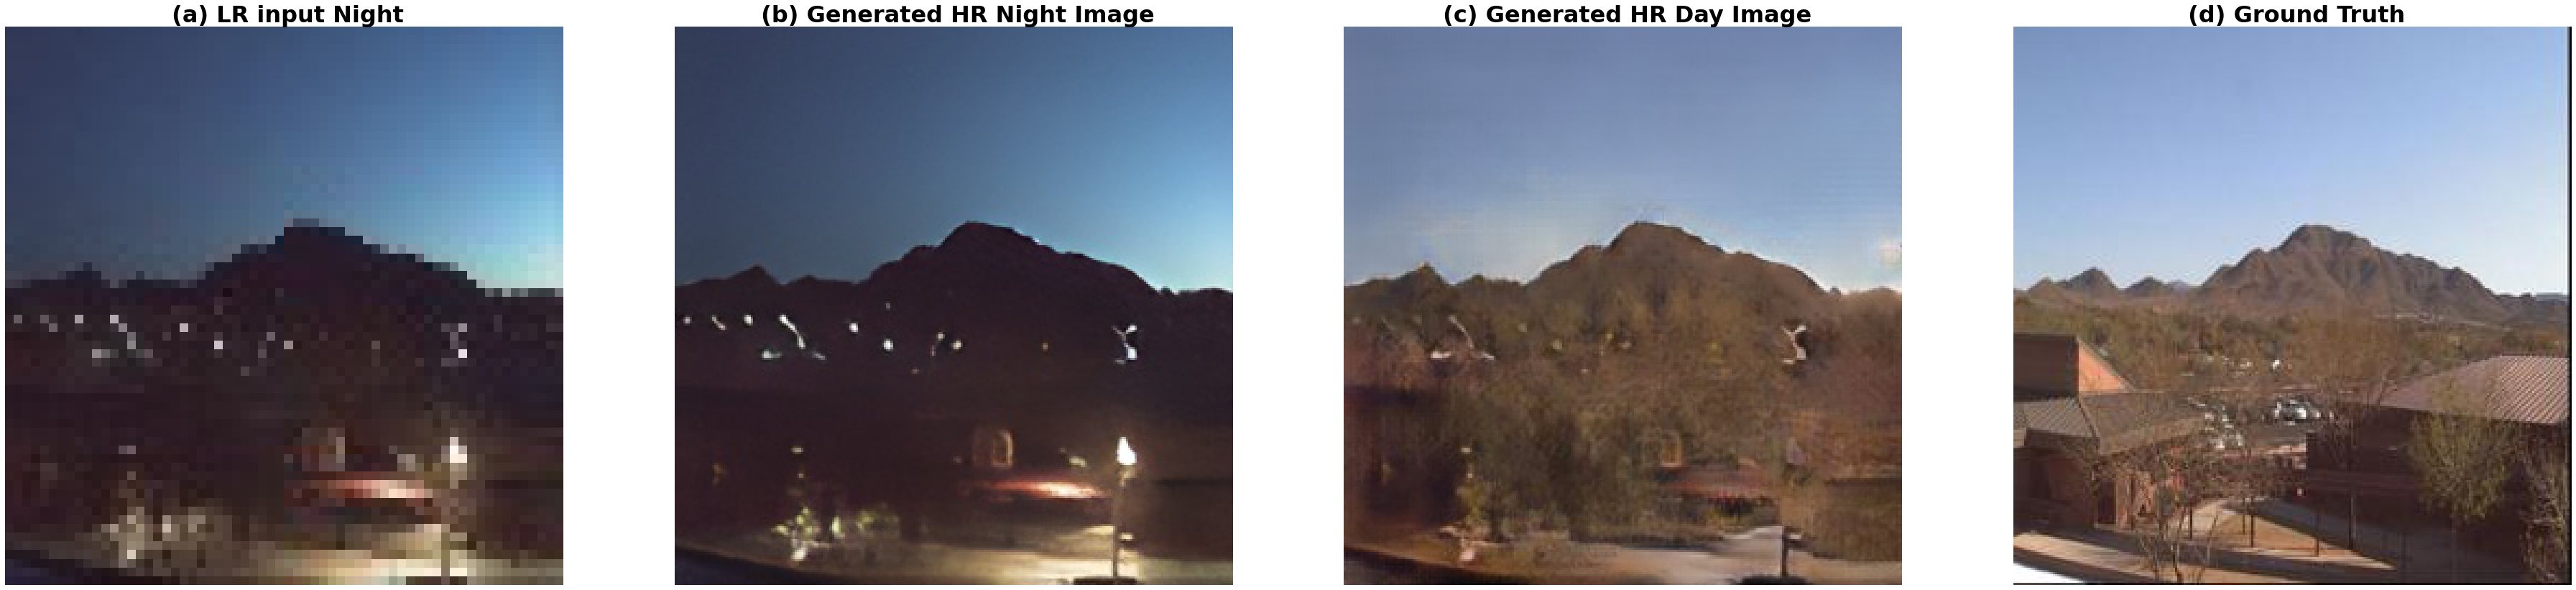

In [53]:
img_num = '7014'

print('Image:', img_num )


MAX_MI_LR_night_path = LR_night_folder_path + img_num + '.jpg'
MAX_MI_HR_Gen_night_path = HR_Gen_night_folder_path + img_num + '_out.jpg'
MAX_MI_HR_Gen_day_path = HR_Gen_day_folder_path + img_num + '_out_fake_B.png'
MAX_MI_Ground_truth_path = Ground_truth_folder_path  + img_num + '.jpg'
                

img_MAX_MI_LR = plt.imread(MAX_MI_LR_night_path)
img_MAX_MI_HR_Gen_night = plt.imread(MAX_MI_HR_Gen_night_path)
img_MAX_MI_HR_Gen_day = plt.imread(MAX_MI_HR_Gen_day_path)
img_MAX_MI_Ground_truth = plt.imread(MAX_MI_Ground_truth_path)
plt.figure(figsize=(64,64))
plt.subplot(141)
plt.imshow(img_MAX_MI_LR)
plt.axis('off')
plt.title(' (a) LR input Night',fontweight="bold", size=32) # Title
plt.subplot(142)
plt.imshow(img_MAX_MI_HR_Gen_night)
plt.axis('off')
plt.title(' (b) Generated HR Night Image',fontweight="bold", size=32) # Title
plt.subplot(143)
plt.imshow(img_MAX_MI_HR_Gen_day)
plt.axis('off')
plt.title(' (c) Generated HR Day Image',fontweight="bold", size=32) # Title
plt.subplot(144)
plt.imshow(img_MAX_MI_Ground_truth)
plt.axis('off')
plt.title(' (d) Ground Truth',fontweight="bold", size=32) # Title

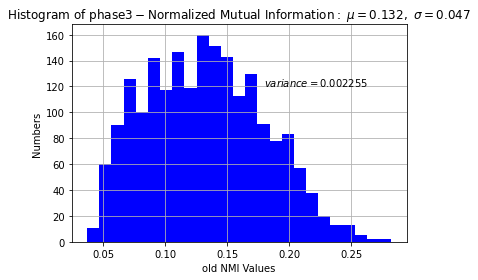

In [54]:
variance_NMI_phase3 = statistics.pvariance(NMI_phase3_dict.values())
sigma_NMI_phase3 = statistics.pstdev(NMI_phase3_dict.values())
mu_NMI_phase3 = statistics.mean(NMI_phase3_dict.values())
                          

plt.hist(NMI_phase3_dict.values(),25, facecolor='b')
#plot
plt.xlabel('old NMI Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 3- Normalized\ Mutual\ Information:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_NMI_phase3, sigma_NMI_phase3))
plt.text(0.18, 120, r'$variance=%.6f$' %(variance_NMI_phase3))
plt.grid(True)
plt.show()

In [55]:
print("NMI Max is" , max(NMI_phase3_dict.values()))
print("NMI Min is" ,min(NMI_phase3_dict.values()))

print("NMI Max image is ", list(NMI_phase3_dict.keys())[list(NMI_phase3_dict.values()).index( max(NMI_phase3_dict.values()))],".jpg")

print("NMI Min image is ", list(NMI_phase3_dict.keys())[list(NMI_phase3_dict.values()).index( min(NMI_phase3_dict.values()))],".jpg")

NMI Max is 0.28255832746819226
NMI Min is 0.036734630634450594
NMI Max image is  3443 .jpg
NMI Min image is  5112 .jpg


Image: 3443


Text(0.5, 1.0, ' (d) Ground Truth')

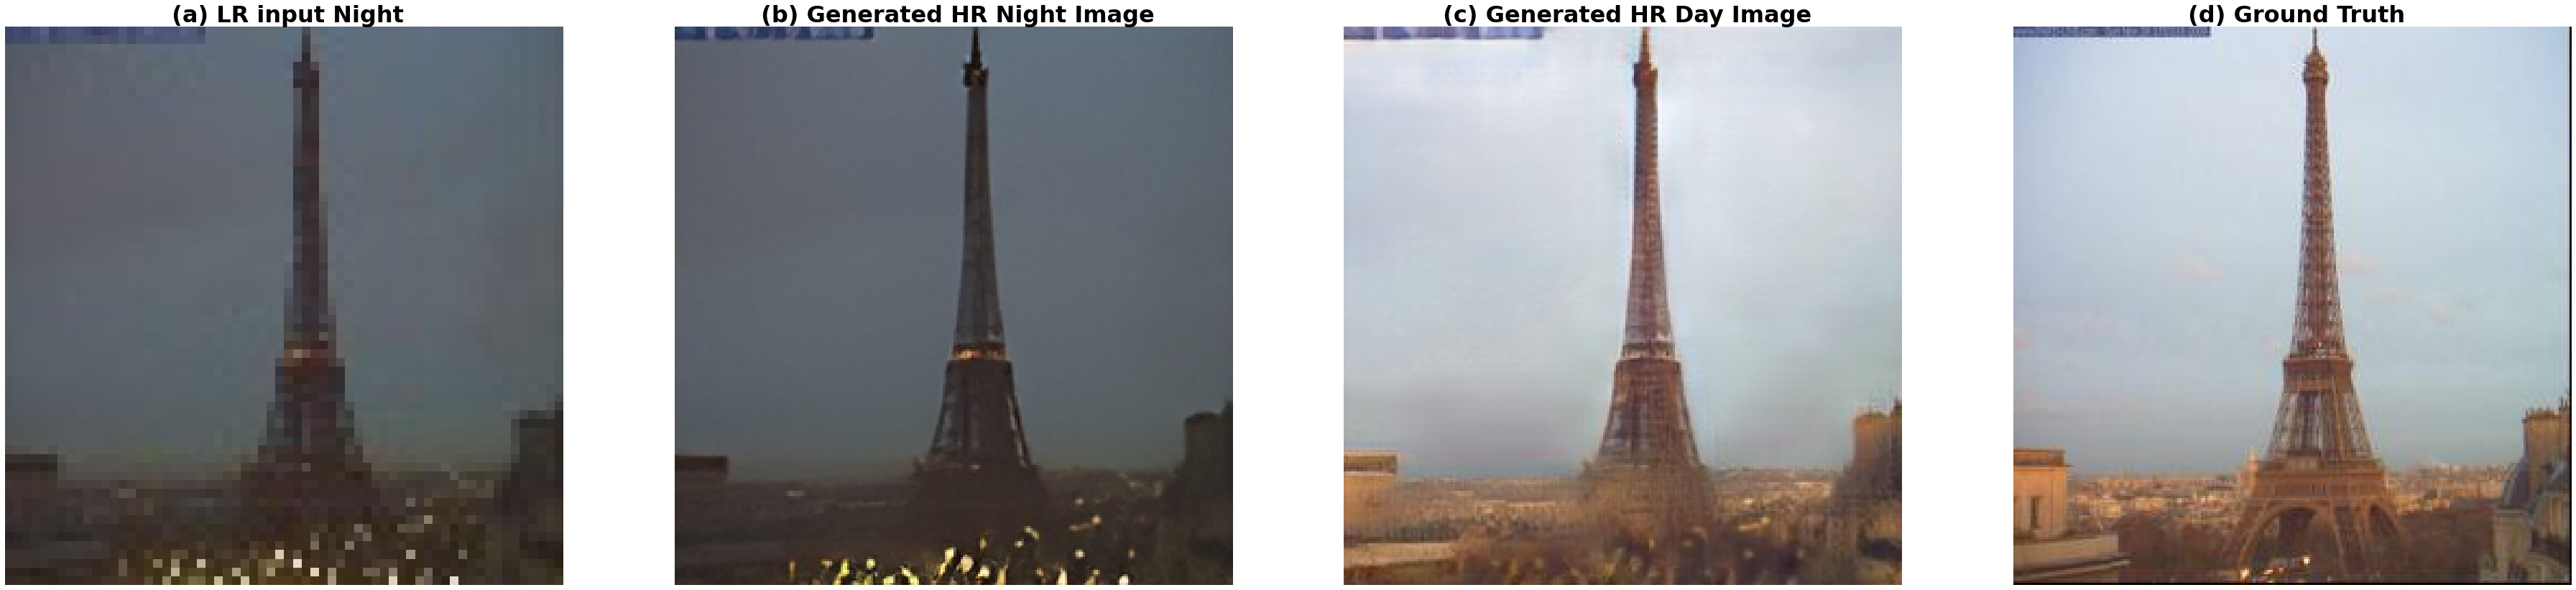

In [56]:
img_num = '3443'

print('Image:', img_num )


MAX_NMI_LR_night_path = LR_night_folder_path + img_num + '.jpg'
MAX_NMI_HR_Gen_night_path = HR_Gen_night_folder_path + img_num + '_out.jpg'
MAX_NMI_HR_Gen_day_path = HR_Gen_day_folder_path + img_num + '_out_fake_B.png'
MAX_NMI_Ground_truth_path = Ground_truth_folder_path  + img_num + '.jpg'
                

img_MAX_NMI_LR = plt.imread(MAX_NMI_LR_night_path)
img_MAX_NMI_HR_Gen_night = plt.imread(MAX_NMI_HR_Gen_night_path)
img_MAX_NMI_HR_Gen_day = plt.imread(MAX_NMI_HR_Gen_day_path)
img_MAX_NMI_Ground_truth = plt.imread(MAX_NMI_Ground_truth_path)
plt.figure(figsize=(64,64))
plt.subplot(141)
plt.imshow(img_MAX_NMI_LR)
plt.axis('off')
plt.title(' (a) LR input Night',fontweight="bold", size=32) # Title
plt.subplot(142)
plt.imshow(img_MAX_NMI_HR_Gen_night)
plt.axis('off')
plt.title(' (b) Generated HR Night Image',fontweight="bold", size=32) # Title
plt.subplot(143)
plt.imshow(img_MAX_NMI_HR_Gen_day)
plt.axis('off')
plt.title(' (c) Generated HR Day Image',fontweight="bold", size=32) # Title
plt.subplot(144)
plt.imshow(img_MAX_NMI_Ground_truth)
plt.axis('off')
plt.title(' (d) Ground Truth',fontweight="bold", size=32) # Title

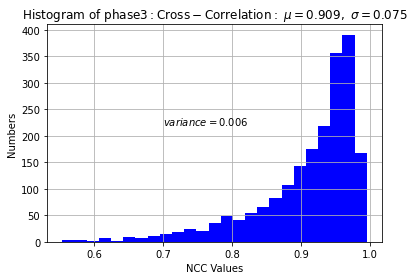

In [142]:
variance_NCC_phase3 = statistics.pvariance(NCC_phase3_dict.values())
sigma_NCC_phase3 = statistics.pstdev(NCC_phase3_dict.values())
mu_NCC_phase3 = statistics.mean(NCC_phase3_dict.values())
                          

plt.hist(NCC_phase3_dict.values(),25, color='b')
#plot
plt.xlabel('NCC Values')
plt.ylabel('Numbers')
plt.title(r'$\mathrm{Histogram\ of\ phase 3: Cross-Correlation:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_NCC_phase3, sigma_NCC_phase3))
plt.text(0.7, 220, r'$variance=%.3f$' %(variance_NCC_phase3))
plt.grid(True)
plt.show()

In [58]:
print("NCC Max is" , max(NCC_phase3_dict.values()))
print("NCC Min is" ,min(NCC_phase3_dict.values()))

print("NCC Max image is ", list(NCC_phase3_dict.keys())[list(NCC_phase3_dict.values()).index( max(NCC_phase3_dict.values()))],".jpg")

print("NCC Min image is ", list(NCC_phase3_dict.keys())[list(NCC_phase3_dict.values()).index( min(NCC_phase3_dict.values()))],".jpg")

NCC Max is 0.9953973889350891
NCC Min is 0.5534494519233704
NCC Max image is  3443 .jpg
NCC Min image is  1533 .jpg


Image: 1739


Text(0.5, 1.0, ' (d) Ground Truth')

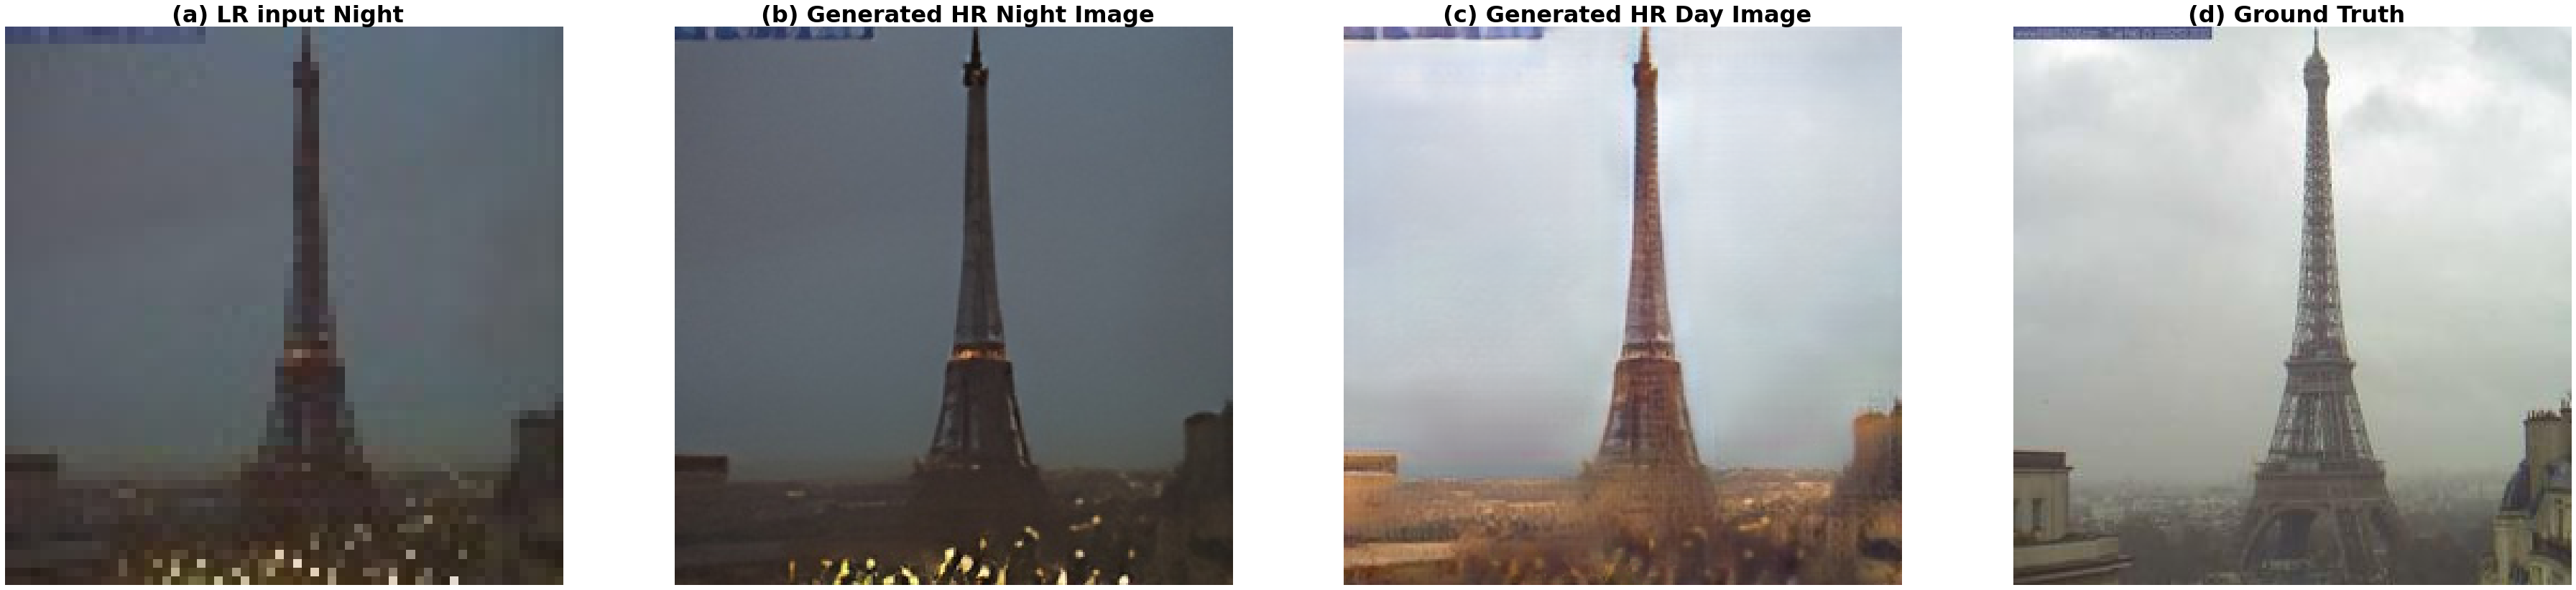

In [59]:
img_num = '1739'

print('Image:', img_num )


MAX_NCC_LR_night_path = LR_night_folder_path + img_num + '.jpg'
MAX_NCC_HR_Gen_night_path = HR_Gen_night_folder_path + img_num + '_out.jpg'
MAX_NCC_HR_Gen_day_path = HR_Gen_day_folder_path + img_num + '_out_fake_B.png'
MAX_NCC_Ground_truth_path = Ground_truth_folder_path  + img_num + '.jpg'
                

img_MAX_NCC_LR = plt.imread(MAX_NCC_LR_night_path)
img_MAX_NCC_HR_Gen_night = plt.imread(MAX_NCC_HR_Gen_night_path)
img_MAX_NCC_HR_Gen_day = plt.imread(MAX_NCC_HR_Gen_day_path)
img_MAX_NCC_Ground_truth = plt.imread(MAX_NCC_Ground_truth_path)
plt.figure(figsize=(64,64))
plt.subplot(141)
plt.imshow(img_MAX_NCC_LR)
plt.axis('off')
plt.title(' (a) LR input Night',fontweight="bold", size=32) # Title
plt.subplot(142)
plt.imshow(img_MAX_NCC_HR_Gen_night)
plt.axis('off')
plt.title(' (b) Generated HR Night Image',fontweight="bold", size=32) # Title
plt.subplot(143)
plt.imshow(img_MAX_NCC_HR_Gen_day)
plt.axis('off')
plt.title(' (c) Generated HR Day Image',fontweight="bold", size=32) # Title
plt.subplot(144)
plt.imshow(img_MAX_NCC_Ground_truth)
plt.axis('off')
plt.title(' (d) Ground Truth',fontweight="bold", size=32) # Title

## FID

In [48]:
!python -m pytorch_fid /home/aabedjoo/Aref_project/Final_results/M2-A1/Generated_HR_Day/ /home/aabedjoo/Aref_project/Main_Dataset/day/test/ --device cuda:0 --dims 768

100%|███████████████████████████████████████████| 41/41 [00:10<00:00,  3.94it/s]
FID:  0.4749448355930683


In [145]:
!python -m pytorch_fid /home/aabedjoo/Aref_project/Final_results/M2-A1/Generated_HR_Day/ /home/aabedjoo/Aref_project/Main_Dataset/day/test/ --device cuda:0

100%|███████████████████████████████████████████| 41/41 [00:08<00:00,  5.12it/s]
FID:  90.47416311416367


In [150]:
FID_phase3 = 90.47416311416367

# Compare Before and After

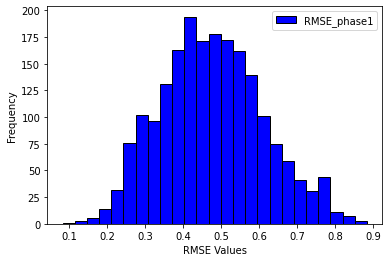

In [176]:
plt.hist(RMSE_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
#plot
plt.xlabel('RMSE Values')
plt.ylabel('Frequency')
plt.legend(["RMSE_phase1"])
plt.grid(False)
plt.show()

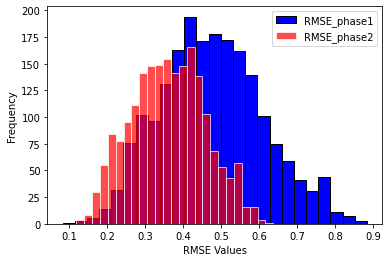

In [177]:
plt.hist(RMSE_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(RMSE_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
#plot
plt.xlabel('RMSE Values')
plt.ylabel('Frequency')
# plt.title(" RMSE_phase1 vs RMSE_phase3" )
plt.legend(["RMSE_phase1","RMSE_phase2"])
plt.grid(False)
plt.show()

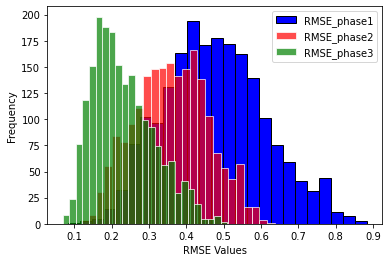

In [178]:
plt.hist(RMSE_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(RMSE_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
plt.hist(RMSE_phase3_dict.values(),25, edgecolor='white', alpha = 0.7, color= 'green')
#plot
#plot
plt.xlabel('RMSE Values')
plt.ylabel('Frequency')
# plt.title(" RMSE_phase1 vs RMSE_phase3" )
plt.legend(["RMSE_phase1","RMSE_phase2","RMSE_phase3"])
plt.grid(False)
plt.show()

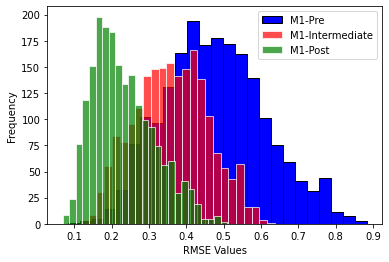

In [175]:
plt.hist(RMSE_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(RMSE_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
plt.hist(RMSE_phase3_dict.values(),25, edgecolor='white', alpha = 0.7, color= 'green')
#plot
#plot
plt.xlabel('RMSE Values')
plt.ylabel('Frequency')
# plt.title(" RMSE_phase1 vs RMSE_phase3" )
plt.legend(["M1-Pre","M1-Intermediate","M1-Post"])
plt.grid(False)
plt.show()

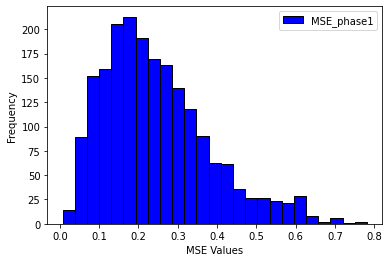

In [179]:
plt.hist(MSE_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
#plot
plt.xlabel('MSE Values')
plt.ylabel('Frequency')
plt.legend(["MSE_phase1"])
plt.grid(False)
plt.show()

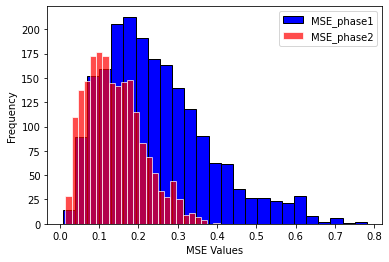

In [180]:
plt.hist(MSE_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(MSE_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
#plot
plt.xlabel('MSE Values')
plt.ylabel('Frequency')
# plt.title(" MSE_phase1 vs MSE_phase3" )
plt.legend(["MSE_phase1","MSE_phase2"])
plt.grid(False)
plt.show()

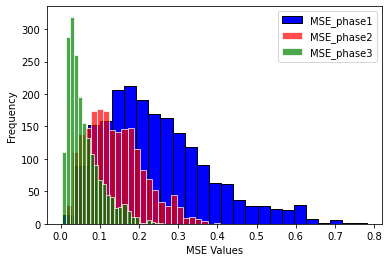

In [181]:
plt.hist(MSE_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(MSE_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
plt.hist(MSE_phase3_dict.values(),25, edgecolor='white', alpha = 0.7, color= 'green')
#plot
#plot
plt.xlabel('MSE Values')
plt.ylabel('Frequency')
# plt.title(" MSE_phase1 vs MSE_phase3" )
plt.legend(["MSE_phase1","MSE_phase2","MSE_phase3"])
plt.grid(False)
plt.show()

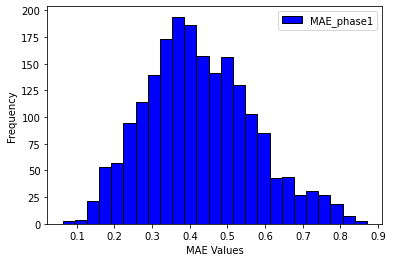

In [182]:
plt.hist(MAE_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
#plot
plt.xlabel('MAE Values')
plt.ylabel('Frequency')
plt.legend(["MAE_phase1"])
plt.grid(False)
plt.show()

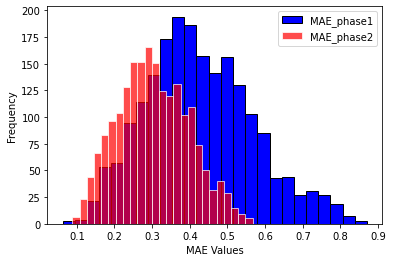

In [183]:
plt.hist(MAE_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(MAE_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
#plot
plt.xlabel('MAE Values')
plt.ylabel('Frequency')
# plt.title(" MAE_phase1 vs MAE_phase3" )
plt.legend(["MAE_phase1","MAE_phase2"])
plt.grid(False)
plt.show()

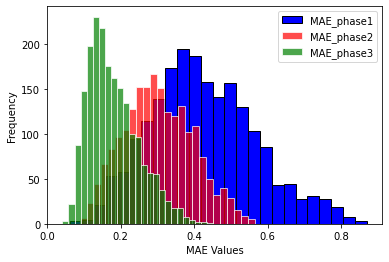

In [184]:
plt.hist(MAE_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(MAE_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
plt.hist(MAE_phase3_dict.values(),25, edgecolor='white', alpha = 0.7, color= 'green')
#plot
#plot
plt.xlabel('MAE Values')
plt.ylabel('Frequency')
# plt.title(" RMSE_phase1 vs RMSE_phase3" )
plt.legend(["MAE_phase1","MAE_phase2","MAE_phase3"])
plt.grid(False)
plt.show()

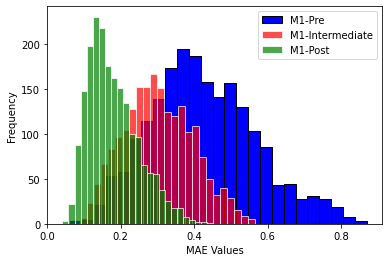

In [186]:
plt.hist(MAE_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(MAE_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
plt.hist(MAE_phase3_dict.values(),25, edgecolor='white', alpha = 0.7, color= 'green')
#plot
#plot
plt.xlabel('MAE Values')
plt.ylabel('Frequency')
# plt.title(" RMSE_phase1 vs RMSE_phase3" )
plt.legend(["M1-Pre","M1-Intermediate","M1-Post"])
plt.grid(False)
plt.show()

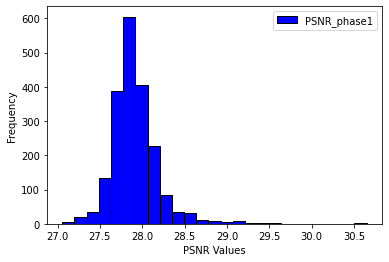

In [187]:
plt.hist(PSNR_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
#plot
plt.xlabel('PSNR Values')
plt.ylabel('Frequency')
plt.legend(["PSNR_phase1"])
plt.grid(False)
plt.show()

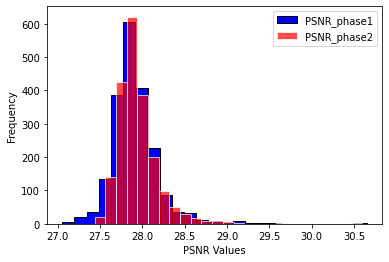

In [188]:
plt.hist(PSNR_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(PSNR_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
#plot
plt.xlabel('PSNR Values')
plt.ylabel('Frequency')
# plt.title(" PSNR_phase1 vs PSNR_phase3" )
plt.legend(["PSNR_phase1","PSNR_phase2"])
plt.grid(False)
plt.show()

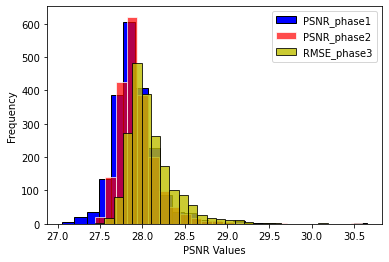

In [189]:
plt.hist(PSNR_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(PSNR_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
plt.hist(PSNR_phase3_dict.values(),25, edgecolor='black', alpha = 0.8, color= 'y')
#plot
#plot
plt.xlabel('PSNR Values')
plt.ylabel('Frequency')
# plt.title("PSNR_phase1 vs PSNR_phase3" )
plt.legend(["PSNR_phase1","PSNR_phase2","RMSE_phase3"])
plt.grid(False)
plt.show()

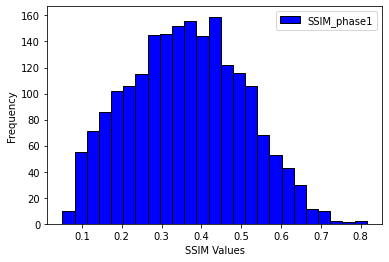

In [190]:
plt.hist(SSIM_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
#plot
plt.xlabel('SSIM Values')
plt.ylabel('Frequency')
plt.legend(["SSIM_phase1"])
plt.grid(False)
plt.show()

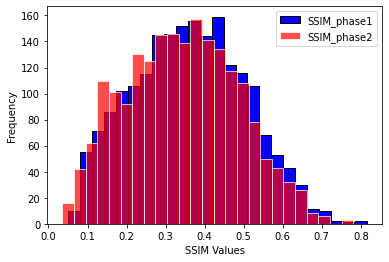

In [191]:
plt.hist(SSIM_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(SSIM_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
#plot
plt.xlabel('SSIM Values')
plt.ylabel('Frequency')
# plt.title(" SSIM_phase1 vs SSIM_phase3" )
plt.legend(["SSIM_phase1","SSIM_phase2"])
plt.grid(False)
plt.show()

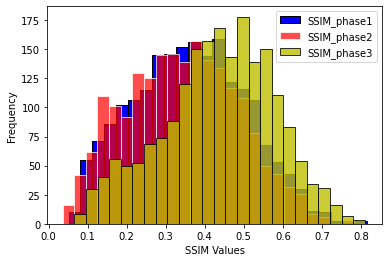

In [192]:
plt.hist(SSIM_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(SSIM_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
plt.hist(SSIM_phase3_dict.values(),25, edgecolor='black', alpha = 0.8, color= 'y')
#plot
#plot
plt.xlabel('SSIM Values')
plt.ylabel('Frequency')
# plt.title(" RMSE_phase1 vs RMSE_phase3" )
plt.legend(["SSIM_phase1","SSIM_phase2","SSIM_phase3"])
plt.grid(False)
plt.show()

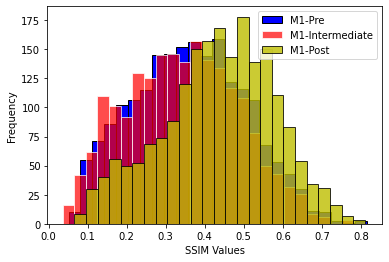

In [198]:
plt.hist(SSIM_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(SSIM_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
plt.hist(SSIM_phase3_dict.values(),25, edgecolor='black', alpha = 0.8, color= 'y')
#plot
#plot
plt.xlabel('SSIM Values')
plt.ylabel('Frequency')
plt.legend(["M1-Pre","M1-Intermediate","M1-Post"])
plt.grid(False)
plt.show()

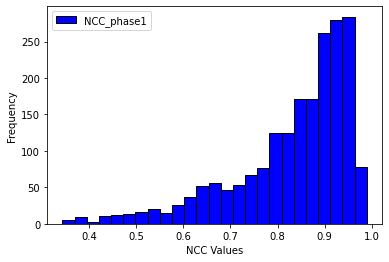

In [195]:
plt.hist(NCC_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
#plot
plt.xlabel('NCC Values')
plt.ylabel('Frequency')
plt.legend(["NCC_phase1"])
plt.grid(False)
plt.show()

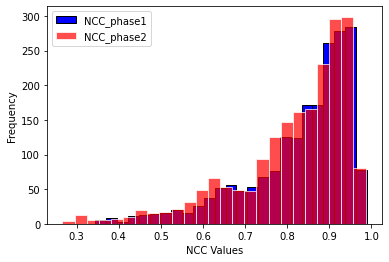

In [196]:
plt.hist(NCC_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(NCC_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
#plot
plt.xlabel('NCC Values')
plt.ylabel('Frequency')
# plt.title(" NCC_phase1 vs NCC_phase3" )
plt.legend(["NCC_phase1","NCC_phase2"])
plt.grid(False)
plt.show()

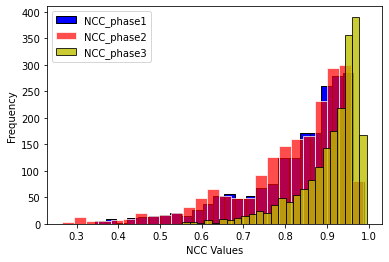

In [197]:
plt.hist(NCC_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(NCC_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
plt.hist(NCC_phase3_dict.values(),25, edgecolor='black', alpha = 0.8, color= 'y')
#plot
#plot
plt.xlabel('NCC Values')
plt.ylabel('Frequency')
# plt.title(" NCC_phase1 vs NCC_phase3" )
plt.legend(["NCC_phase1","NCC_phase2","NCC_phase3"])
plt.grid(False)
plt.show()

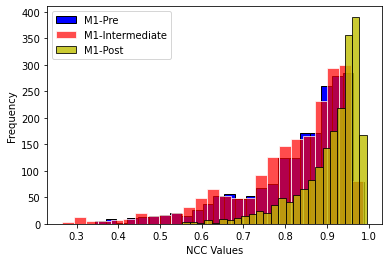

In [199]:
plt.hist(NCC_phase1_dict.values(),25, facecolor='blue',edgecolor='black')
plt.hist(NCC_phase2_dict.values(),25, facecolor='red',alpha = 0.7,edgecolor='white')
plt.hist(NCC_phase3_dict.values(),25, edgecolor='black', alpha = 0.8, color= 'y')
#plot
#plot
plt.xlabel('NCC Values')
plt.ylabel('Frequency')
# plt.title(" NCC_phase1 vs NCC_phase3" )
plt.legend(["M1-Pre","M1-Intermediate","M1-Post"])
plt.grid(False)
plt.show()

(-0.5, 255.5, 255.5, -0.5)

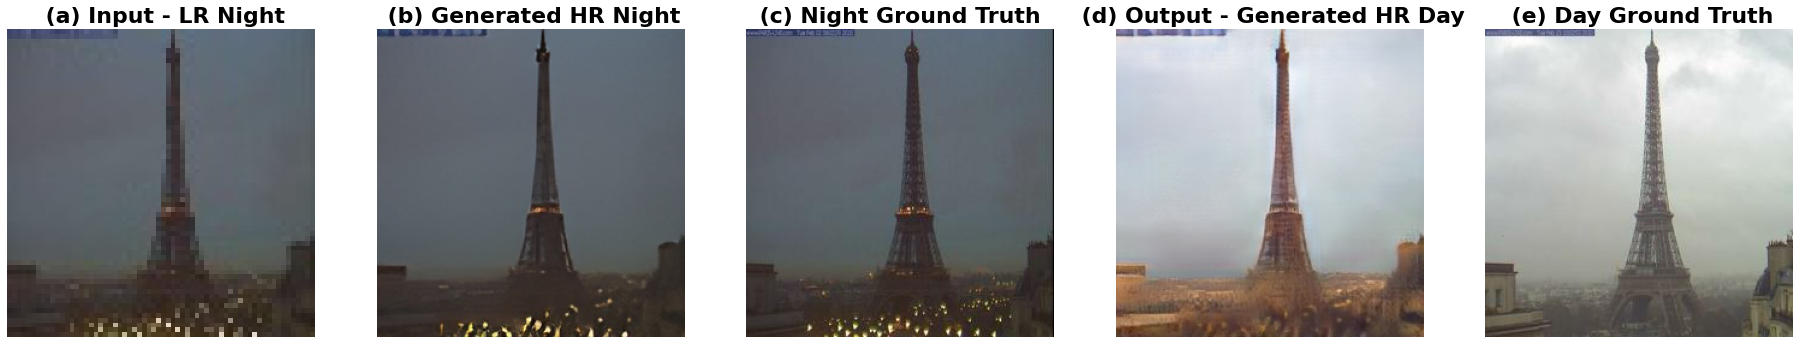

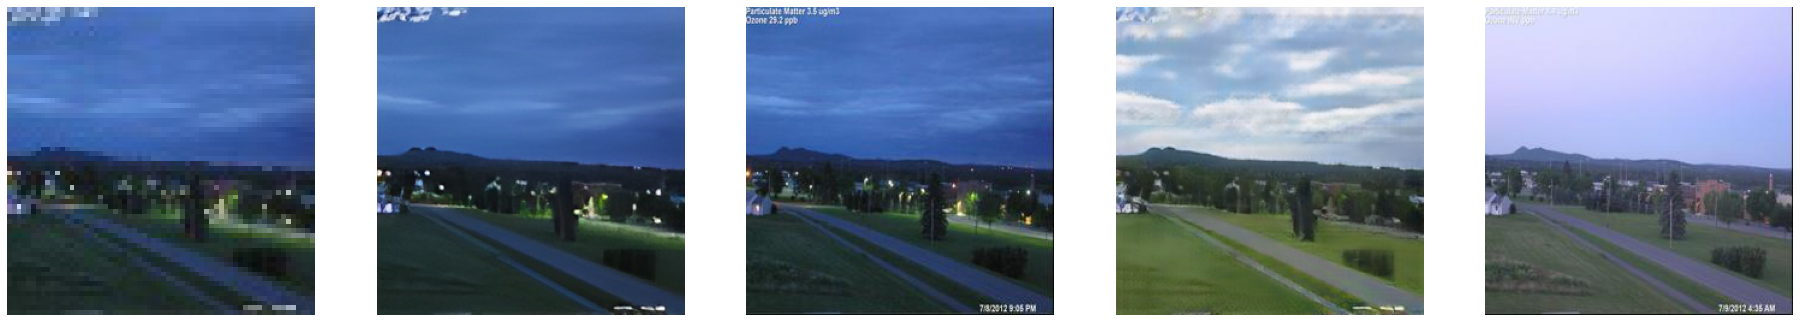

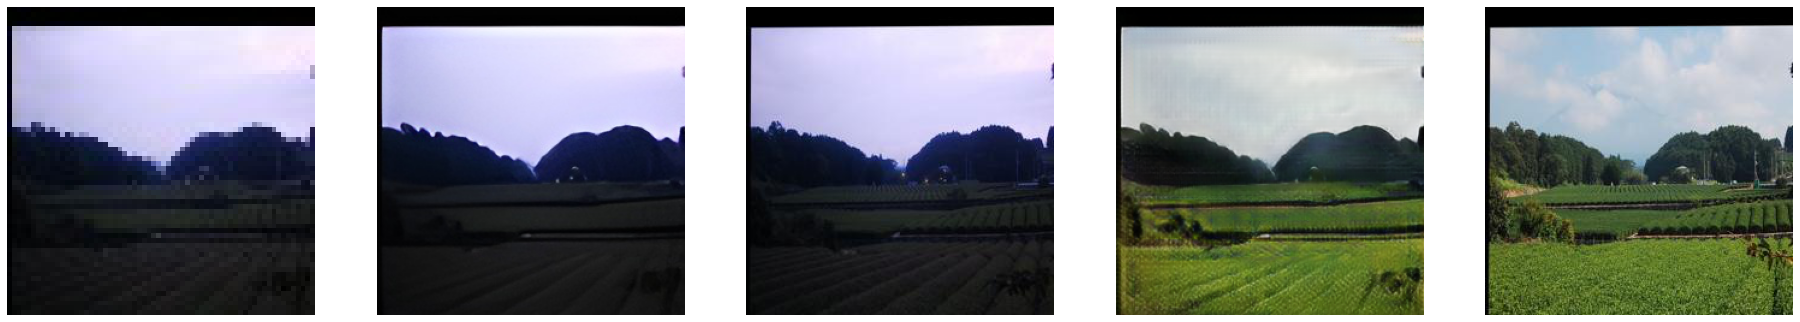

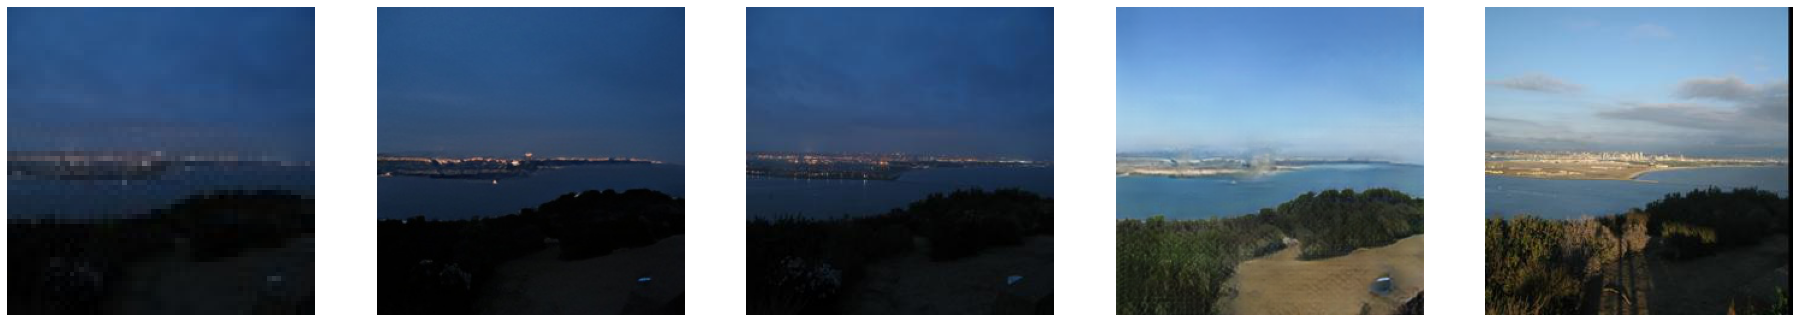

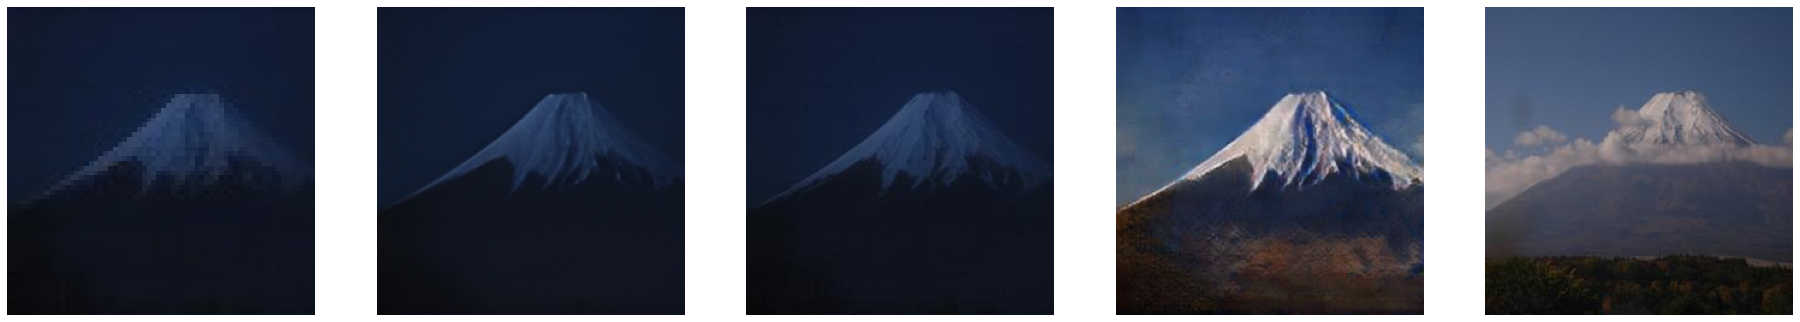

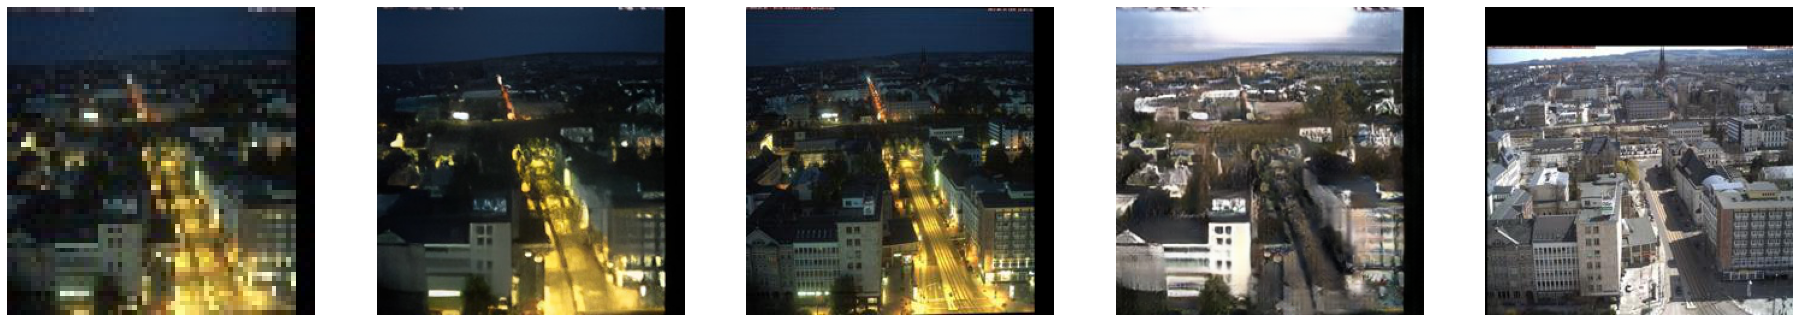

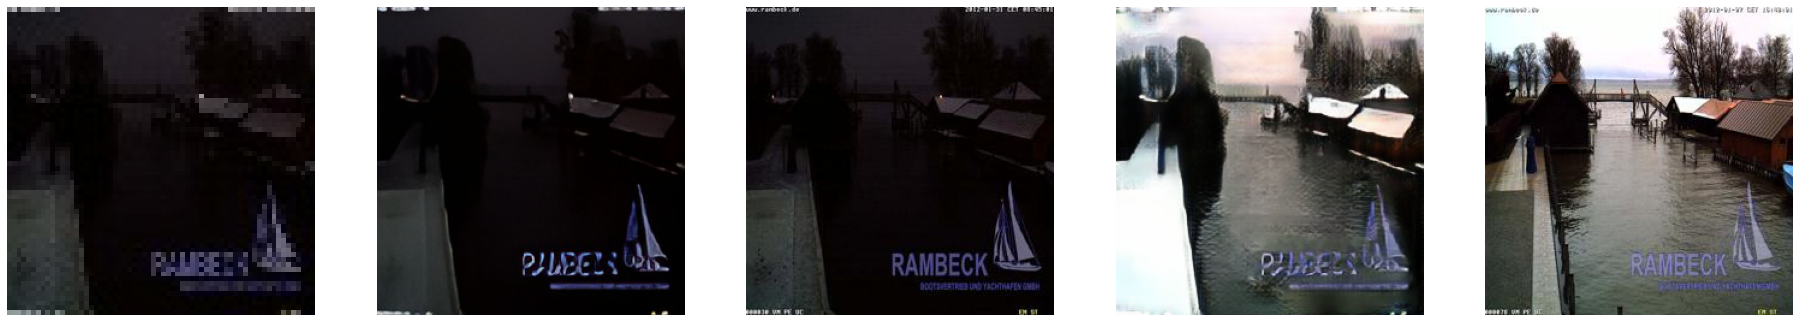

In [124]:
img_num = '1739'

M2_A1_LR_night_path = LR_night_folder_path + img_num + '.jpg'
M2_A1_HR_Gen_night_path = HR_Gen_night_folder_path + img_num + '_out.jpg'
M2_A1_HR_Gen_day_path = HR_Gen_day_folder_path + img_num + '_out_fake_B.png'
M2_A1_Ground_truth_path = Ground_truth_folder_path  + img_num + '.jpg'
M2_A1_Night_Ground_truth_path = Night_Ground_truth_folder_path  + img_num + '.jpg'         

img_M2_A1_LR = plt.imread(M2_A1_LR_night_path)
img_M2_A1_HR_Gen_night = plt.imread(M2_A1_HR_Gen_night_path)
img_M2_A1_HR_Gen_day = plt.imread(M2_A1_HR_Gen_day_path)
img_M2_A1_Ground_truth = plt.imread(M2_A1_Ground_truth_path)
img_M2_A1_Night_Ground_truth = plt.imread(M2_A1_Night_Ground_truth_path)
plt.figure(figsize=(32,32))
plt.subplot(151)
plt.imshow(img_M2_A1_LR)
plt.axis('off')
plt.title(' (a) Input - LR Night',fontweight="bold", size=22) # Title
plt.subplot(152)
plt.imshow(img_M2_A1_HR_Gen_night)
plt.axis('off')
plt.title(' (b) Generated HR Night',fontweight="bold", size=22) # Title
plt.subplot(153)
plt.imshow(img_M2_A1_Night_Ground_truth)
plt.axis('off')
plt.title(' (c) Night Ground Truth ',fontweight="bold", size=22) # Title
plt.subplot(154)
plt.imshow(img_M2_A1_HR_Gen_day)
plt.axis('off')
plt.title(' (d) Output - Generated HR Day',fontweight="bold", size=22) # Title
plt.subplot(155)
plt.imshow(img_M2_A1_Ground_truth)
plt.axis('off')
plt.title(' (e) Day Ground Truth',fontweight="bold", size=22) # Title



img_num = '2510'

M2_A1_LR_night_path = LR_night_folder_path + img_num + '.jpg'
M2_A1_HR_Gen_night_path = HR_Gen_night_folder_path + img_num + '_out.jpg'
M2_A1_HR_Gen_day_path = HR_Gen_day_folder_path + img_num + '_out_fake_B.png'
M2_A1_Ground_truth_path = Ground_truth_folder_path  + img_num + '.jpg'
M2_A1_Night_Ground_truth_path = Night_Ground_truth_folder_path  + img_num + '.jpg'         

img_M2_A1_LR = plt.imread(M2_A1_LR_night_path)
img_M2_A1_HR_Gen_night = plt.imread(M2_A1_HR_Gen_night_path)
img_M2_A1_HR_Gen_day = plt.imread(M2_A1_HR_Gen_day_path)
img_M2_A1_Ground_truth = plt.imread(M2_A1_Ground_truth_path)
img_M2_A1_Night_Ground_truth = plt.imread(M2_A1_Night_Ground_truth_path)
plt.figure(figsize=(32,32))
plt.subplot(151)
plt.imshow(img_M2_A1_LR)
plt.axis('off')
plt.subplot(152)
plt.imshow(img_M2_A1_HR_Gen_night)
plt.axis('off')
plt.subplot(153)
plt.imshow(img_M2_A1_Night_Ground_truth)
plt.axis('off')
plt.subplot(154)
plt.imshow(img_M2_A1_HR_Gen_day)
plt.axis('off')
plt.subplot(155)
plt.imshow(img_M2_A1_Ground_truth)
plt.axis('off')





img_num = '7496'

M2_A1_LR_night_path = LR_night_folder_path + img_num + '.jpg'
M2_A1_HR_Gen_night_path = HR_Gen_night_folder_path + img_num + '_out.jpg'
M2_A1_HR_Gen_day_path = HR_Gen_day_folder_path + img_num + '_out_fake_B.png'
M2_A1_Ground_truth_path = Ground_truth_folder_path  + img_num + '.jpg'
M2_A1_Night_Ground_truth_path = Night_Ground_truth_folder_path  + img_num + '.jpg'         

img_M2_A1_LR = plt.imread(M2_A1_LR_night_path)
img_M2_A1_HR_Gen_night = plt.imread(M2_A1_HR_Gen_night_path)
img_M2_A1_HR_Gen_day = plt.imread(M2_A1_HR_Gen_day_path)
img_M2_A1_Ground_truth = plt.imread(M2_A1_Ground_truth_path)
img_M2_A1_Night_Ground_truth = plt.imread(M2_A1_Night_Ground_truth_path)
plt.figure(figsize=(32,32))
plt.subplot(151)
plt.imshow(img_M2_A1_LR)
plt.axis('off')
plt.subplot(152)
plt.imshow(img_M2_A1_HR_Gen_night)
plt.axis('off')
plt.subplot(153)
plt.imshow(img_M2_A1_Night_Ground_truth)
plt.axis('off')
plt.subplot(154)
plt.imshow(img_M2_A1_HR_Gen_day)
plt.axis('off')
plt.subplot(155)
plt.imshow(img_M2_A1_Ground_truth)
plt.axis('off')

img_num = '10395'

M2_A1_LR_night_path = LR_night_folder_path + img_num + '.jpg'
M2_A1_HR_Gen_night_path = HR_Gen_night_folder_path + img_num + '_out.jpg'
M2_A1_HR_Gen_day_path = HR_Gen_day_folder_path + img_num + '_out_fake_B.png'
M2_A1_Ground_truth_path = Ground_truth_folder_path  + img_num + '.jpg'
M2_A1_Night_Ground_truth_path = Night_Ground_truth_folder_path  + img_num + '.jpg'         

img_M2_A1_LR = plt.imread(M2_A1_LR_night_path)
img_M2_A1_HR_Gen_night = plt.imread(M2_A1_HR_Gen_night_path)
img_M2_A1_HR_Gen_day = plt.imread(M2_A1_HR_Gen_day_path)
img_M2_A1_Ground_truth = plt.imread(M2_A1_Ground_truth_path)
img_M2_A1_Night_Ground_truth = plt.imread(M2_A1_Night_Ground_truth_path)
plt.figure(figsize=(32,32))
plt.subplot(151)
plt.imshow(img_M2_A1_LR)
plt.axis('off')
plt.subplot(152)
plt.imshow(img_M2_A1_HR_Gen_night)
plt.axis('off')
plt.subplot(153)
plt.imshow(img_M2_A1_Night_Ground_truth)
plt.axis('off')
plt.subplot(154)
plt.imshow(img_M2_A1_HR_Gen_day)
plt.axis('off')
plt.subplot(155)
plt.imshow(img_M2_A1_Ground_truth)
plt.axis('off')


# img_num = '13282'

# M2_A1_LR_night_path = LR_night_folder_path + img_num + '.jpg'
# M2_A1_HR_Gen_night_path = HR_Gen_night_folder_path + img_num + '_out.jpg'
# M2_A1_HR_Gen_day_path = HR_Gen_day_folder_path + img_num + '_out_fake_B.png'
# M2_A1_Ground_truth_path = Ground_truth_folder_path  + img_num + '.jpg'
# M2_A1_Night_Ground_truth_path = Night_Ground_truth_folder_path  + img_num + '.jpg'         

# img_M2_A1_LR = plt.imread(M2_A1_LR_night_path)
# img_M2_A1_HR_Gen_night = plt.imread(M2_A1_HR_Gen_night_path)
# img_M2_A1_HR_Gen_day = plt.imread(M2_A1_HR_Gen_day_path)
# img_M2_A1_Ground_truth = plt.imread(M2_A1_Ground_truth_path)
# img_M2_A1_Night_Ground_truth = plt.imread(M2_A1_Night_Ground_truth_path)
# plt.figure(figsize=(32,32))
# plt.subplot(151)
# plt.imshow(img_M2_A1_LR)
# plt.axis('off')
# plt.subplot(152)
# plt.imshow(img_M2_A1_HR_Gen_night)
# plt.axis('off')
# plt.subplot(153)
# plt.imshow(img_M2_A1_Night_Ground_truth)
# plt.axis('off')
# plt.subplot(154)
# plt.imshow(img_M2_A1_HR_Gen_day)
# plt.axis('off')
# plt.subplot(155)
# plt.imshow(img_M2_A1_Ground_truth)
# plt.axis('off')


img_num = '14383'

M2_A1_LR_night_path = LR_night_folder_path + img_num + '.jpg'
M2_A1_HR_Gen_night_path = HR_Gen_night_folder_path + img_num + '_out.jpg'
M2_A1_HR_Gen_day_path = HR_Gen_day_folder_path + img_num + '_out_fake_B.png'
M2_A1_Ground_truth_path = Ground_truth_folder_path  + img_num + '.jpg'
M2_A1_Night_Ground_truth_path = Night_Ground_truth_folder_path  + img_num + '.jpg'         

img_M2_A1_LR = plt.imread(M2_A1_LR_night_path)
img_M2_A1_HR_Gen_night = plt.imread(M2_A1_HR_Gen_night_path)
img_M2_A1_HR_Gen_day = plt.imread(M2_A1_HR_Gen_day_path)
img_M2_A1_Ground_truth = plt.imread(M2_A1_Ground_truth_path)
img_M2_A1_Night_Ground_truth = plt.imread(M2_A1_Night_Ground_truth_path)
plt.figure(figsize=(32,32))
plt.subplot(151)
plt.imshow(img_M2_A1_LR)
plt.axis('off')
plt.subplot(152)
plt.imshow(img_M2_A1_HR_Gen_night)
plt.axis('off')
plt.subplot(153)
plt.imshow(img_M2_A1_Night_Ground_truth)
plt.axis('off')
plt.subplot(154)
plt.imshow(img_M2_A1_HR_Gen_day)
plt.axis('off')
plt.subplot(155)
plt.imshow(img_M2_A1_Ground_truth)
plt.axis('off')




# img_num = '14369'
# img_num = '8946'

# M2_A1_LR_night_path = LR_night_folder_path + img_num + '.jpg'
# M2_A1_HR_Gen_night_path = HR_Gen_night_folder_path + img_num + '_out.jpg'
# M2_A1_HR_Gen_day_path = HR_Gen_day_folder_path + img_num + '_out_fake_B.png'
# M2_A1_Ground_truth_path = Ground_truth_folder_path  + img_num + '.jpg'
# M2_A1_Night_Ground_truth_path = Night_Ground_truth_folder_path  + img_num + '.jpg'         

# img_M2_A1_LR = plt.imread(M2_A1_LR_night_path)
# img_M2_A1_HR_Gen_night = plt.imread(M2_A1_HR_Gen_night_path)
# img_M2_A1_HR_Gen_day = plt.imread(M2_A1_HR_Gen_day_path)
# img_M2_A1_Ground_truth = plt.imread(M2_A1_Ground_truth_path)
# img_M2_A1_Night_Ground_truth = plt.imread(M2_A1_Night_Ground_truth_path)
# plt.figure(figsize=(32,32))
# plt.subplot(151)
# plt.imshow(img_M2_A1_LR)
# plt.axis('off')
# plt.subplot(152)
# plt.imshow(img_M2_A1_HR_Gen_night)
# plt.axis('off')
# plt.subplot(153)
# plt.imshow(img_M2_A1_Night_Ground_truth)
# plt.axis('off')
# plt.subplot(154)
# plt.imshow(img_M2_A1_HR_Gen_day)
# plt.axis('off')
# plt.subplot(155)
# plt.imshow(img_M2_A1_Ground_truth)
# plt.axis('off')



img_num = '213'

M2_A1_LR_night_path = LR_night_folder_path + img_num + '.jpg'
M2_A1_HR_Gen_night_path = HR_Gen_night_folder_path + img_num + '_out.jpg'
M2_A1_HR_Gen_day_path = HR_Gen_day_folder_path + img_num + '_out_fake_B.png'
M2_A1_Ground_truth_path = Ground_truth_folder_path  + img_num + '.jpg'
M2_A1_Night_Ground_truth_path = Night_Ground_truth_folder_path  + img_num + '.jpg'         

img_M2_A1_LR = plt.imread(M2_A1_LR_night_path)
img_M2_A1_HR_Gen_night = plt.imread(M2_A1_HR_Gen_night_path)
img_M2_A1_HR_Gen_day = plt.imread(M2_A1_HR_Gen_day_path)
img_M2_A1_Ground_truth = plt.imread(M2_A1_Ground_truth_path)
img_M2_A1_Night_Ground_truth = plt.imread(M2_A1_Night_Ground_truth_path)
plt.figure(figsize=(32,32))
plt.subplot(151)
plt.imshow(img_M2_A1_LR)
plt.axis('off')
plt.subplot(152)
plt.imshow(img_M2_A1_HR_Gen_night)
plt.axis('off')
plt.subplot(153)
plt.imshow(img_M2_A1_Night_Ground_truth)
plt.axis('off')
plt.subplot(154)
plt.imshow(img_M2_A1_HR_Gen_day)
plt.axis('off')
plt.subplot(155)
plt.imshow(img_M2_A1_Ground_truth)
plt.axis('off')

img_num = '216'

M2_A1_LR_night_path = LR_night_folder_path + img_num + '.jpg'
M2_A1_HR_Gen_night_path = HR_Gen_night_folder_path + img_num + '_out.jpg'
M2_A1_HR_Gen_day_path = HR_Gen_day_folder_path + img_num + '_out_fake_B.png'
M2_A1_Ground_truth_path = Ground_truth_folder_path  + img_num + '.jpg'
M2_A1_Night_Ground_truth_path = Night_Ground_truth_folder_path  + img_num + '.jpg'         

img_M2_A1_LR = plt.imread(M2_A1_LR_night_path)
img_M2_A1_HR_Gen_night = plt.imread(M2_A1_HR_Gen_night_path)
img_M2_A1_HR_Gen_day = plt.imread(M2_A1_HR_Gen_day_path)
img_M2_A1_Ground_truth = plt.imread(M2_A1_Ground_truth_path)
img_M2_A1_Night_Ground_truth = plt.imread(M2_A1_Night_Ground_truth_path)
plt.figure(figsize=(32,32))
plt.subplot(151)
plt.imshow(img_M2_A1_LR)
plt.axis('off')
plt.subplot(152)
plt.imshow(img_M2_A1_HR_Gen_night)
plt.axis('off')
plt.subplot(153)
plt.imshow(img_M2_A1_Night_Ground_truth)
plt.axis('off')
plt.subplot(154)
plt.imshow(img_M2_A1_HR_Gen_day)
plt.axis('off')
plt.subplot(155)
plt.imshow(img_M2_A1_Ground_truth)
plt.axis('off')

In [152]:
import pandas as pd
str_RMSE_phase1 = str(format(mu_RMSE_phase1,'0.2f')) + " \u00B1 " + str(format(sigma_RMSE_phase1,'0.2f'))
str_RMSE_phase2 = str(format(mu_RMSE_phase2,'0.2f')) + " \u00B1 " + str(format(sigma_RMSE_phase2,'0.2f'))
str_RMSE_phase3 = str(format(mu_RMSE_phase3,'0.2f')) + " \u00B1 " + str(format(sigma_RMSE_phase3,'0.2f'))

str_MSE_phase1 = str(format(mu_MSE_phase1,'0.2f')) + " \u00B1 " + str(format(sigma_MSE_phase1,'0.2f'))
str_MSE_phase2 = str(format(mu_MSE_phase2,'0.2f')) + " \u00B1 " + str(format(sigma_MSE_phase2,'0.2f'))
str_MSE_phase3 = str(format(mu_MSE_phase3,'0.2f')) + " \u00B1 " + str(format(sigma_MSE_phase3,'0.2f'))

str_MAE_phase1 = str(format(mu_MAE_phase1,'0.2f')) + " \u00B1 " + str(format(sigma_MAE_phase1,'0.2f'))
str_MAE_phase2 = str(format(mu_MAE_phase2,'0.2f')) + " \u00B1 " + str(format(sigma_MAE_phase2,'0.2f'))
str_MAE_phase3 = str(format(mu_MSE_phase3,'0.2f')) + " \u00B1 " + str(format(sigma_MSE_phase3,'0.2f'))

str_PSNR_phase1 = str(format(mu_PSNR_phase1,'0.2f')) + " \u00B1 " + str(format(sigma_PSNR_phase1,'0.2f'))
str_PSNR_phase2 = str(format(mu_PSNR_phase2,'0.2f')) + " \u00B1 " + str(format(sigma_PSNR_phase2,'0.2f'))
str_PSNR_phase3 = str(format(mu_PSNR_phase3,'0.2f')) + " \u00B1 " + str(format(sigma_PSNR_phase3,'0.2f'))

str_SSIM_phase1 = str(format(mu_SSIM_phase1,'0.2f')) + " \u00B1 " + str(format(sigma_SSIM_phase1,'0.2f'))
str_SSIM_phase2 = str(format(mu_SSIM_phase2,'0.2f')) + " \u00B1 " + str(format(sigma_SSIM_phase2,'0.2f'))
str_SSIM_phase3 = str(format(mu_SSIM_phase3,'0.2f')) + " \u00B1 " + str(format(sigma_SSIM_phase3,'0.2f'))

str_NCC_phase1 = str(format(mu_NCC_phase1,'0.2f')) + " \u00B1 " + str(format(sigma_NCC_phase1,'0.2f'))
str_NCC_phase2 = str(format(mu_NCC_phase2,'0.2f')) + " \u00B1 " + str(format(sigma_NCC_phase2,'0.2f'))
str_NCC_phase3 = str(format(mu_NCC_phase3,'0.2f')) + " \u00B1 " + str(format(sigma_NCC_phase3,'0.2f'))

# list of strings
RMSE = [str_RMSE_phase1, str_RMSE_phase2, str_RMSE_phase3]
MSE = [str_MSE_phase1, str_MSE_phase2, str_MSE_phase3 ]
MAE = [str_MAE_phase1, str_MAE_phase2, str_MAE_phase3]
PSNR = [str_PSNR_phase1, str_PSNR_phase2, str_PSNR_phase3]
SSIM = [str_SSIM_phase1, str_SSIM_phase2, str_SSIM_phase3]
NCC = [str_NCC_phase1, str_NCC_phase2, str_NCC_phase3]
FID = [str(format(FID_phase1,'0.2f')),str(format(FID_phase2,'0.2f')) ,str(format(FID_phase3,'0.2f'))]

df = pd.DataFrame(list(zip(RMSE, MSE, MAE, PSNR, SSIM, NCC, FID)),
columns =['RMSE_mean', 'MSE_mean', 'MAE_mean', 'PSNR_mean', 'SSIM_mean','NCC_mean', 'FID'],
                  index=["Phase1","Phase2","Phase3"])
df

RMSE_mean     MSE_mean     MAE_mean     PSNR_mean    SSIM_mean  \
Phase1  0.48 ± 0.14  0.25 ± 0.14  0.43 ± 0.14  27.91 ± 0.28  0.36 ± 0.14   
Phase2  0.36 ± 0.10  0.14 ± 0.07  0.30 ± 0.09  27.94 ± 0.23  0.34 ± 0.14   
Phase3  0.23 ± 0.08  0.06 ± 0.04  0.06 ± 0.04  28.10 ± 0.28  0.43 ± 0.14   

           NCC_mean     FID  
Phase1  0.83 ± 0.13  173.95  
Phase2  0.81 ± 0.14  146.76  
Phase3  0.91 ± 0.08   90.47